In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

# import awkward as ak
# import mplhep as hep
# import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
# import re
# import copy

import time
from timeout_decorator import timeout

from LoadBatch import *

verbose = False
debug = False

In [2]:
pd.set_option('display.max_columns', None)
# plt.rcParams['text.usetex'] = True   ### LateX in matplotlib
# !ls ../Data_TestBeam/2023_May/

In [3]:
# plt.style.use(hep.atlas.style.ATLAS)

### Generic bins options, sensors and runs import

In [4]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins = (np.arange(450, 700, 1),
        np.arange(150, 500, 1))

small_bins = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")
dict_of_runs = read_pickle("dict_of_runs.pickle")
if verbose: 
    print(sensors_list)
    print(dict_of_runs)

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

## Plot a single batch

Batch:  410
S1
DUT_0
DUT_1
DUT_2


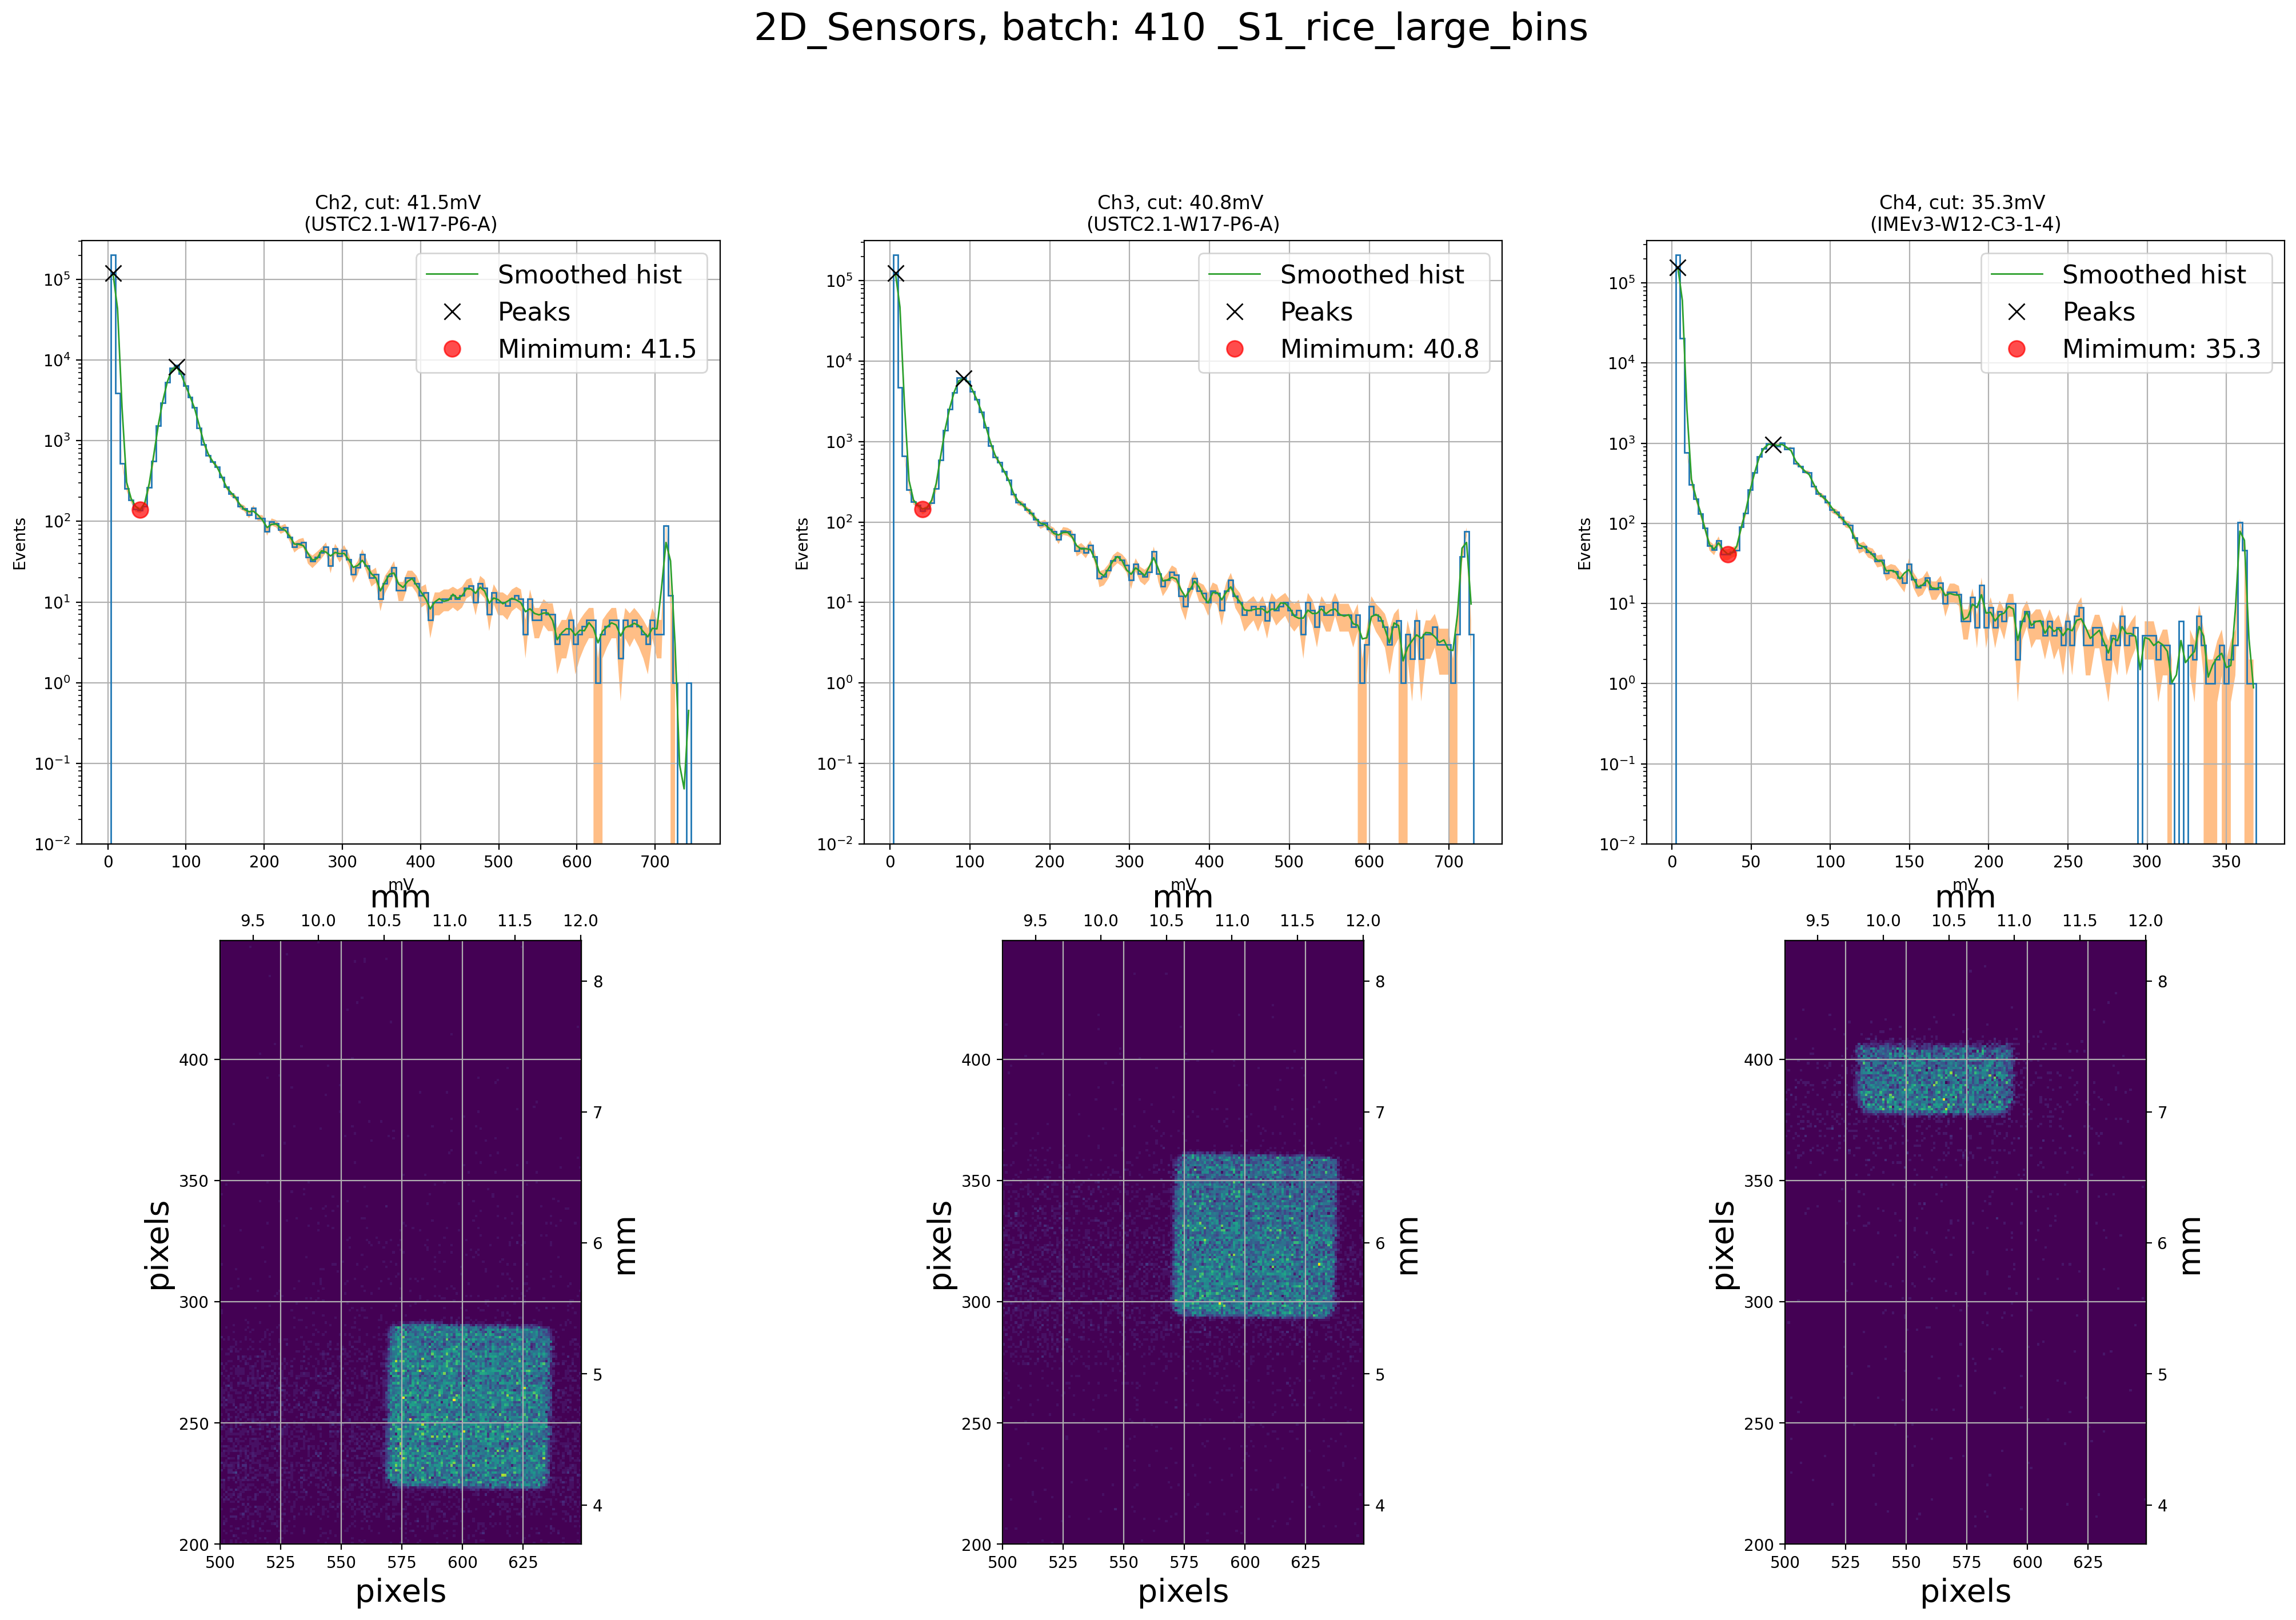

S2
DUT_0
DUT_1
DUT_2


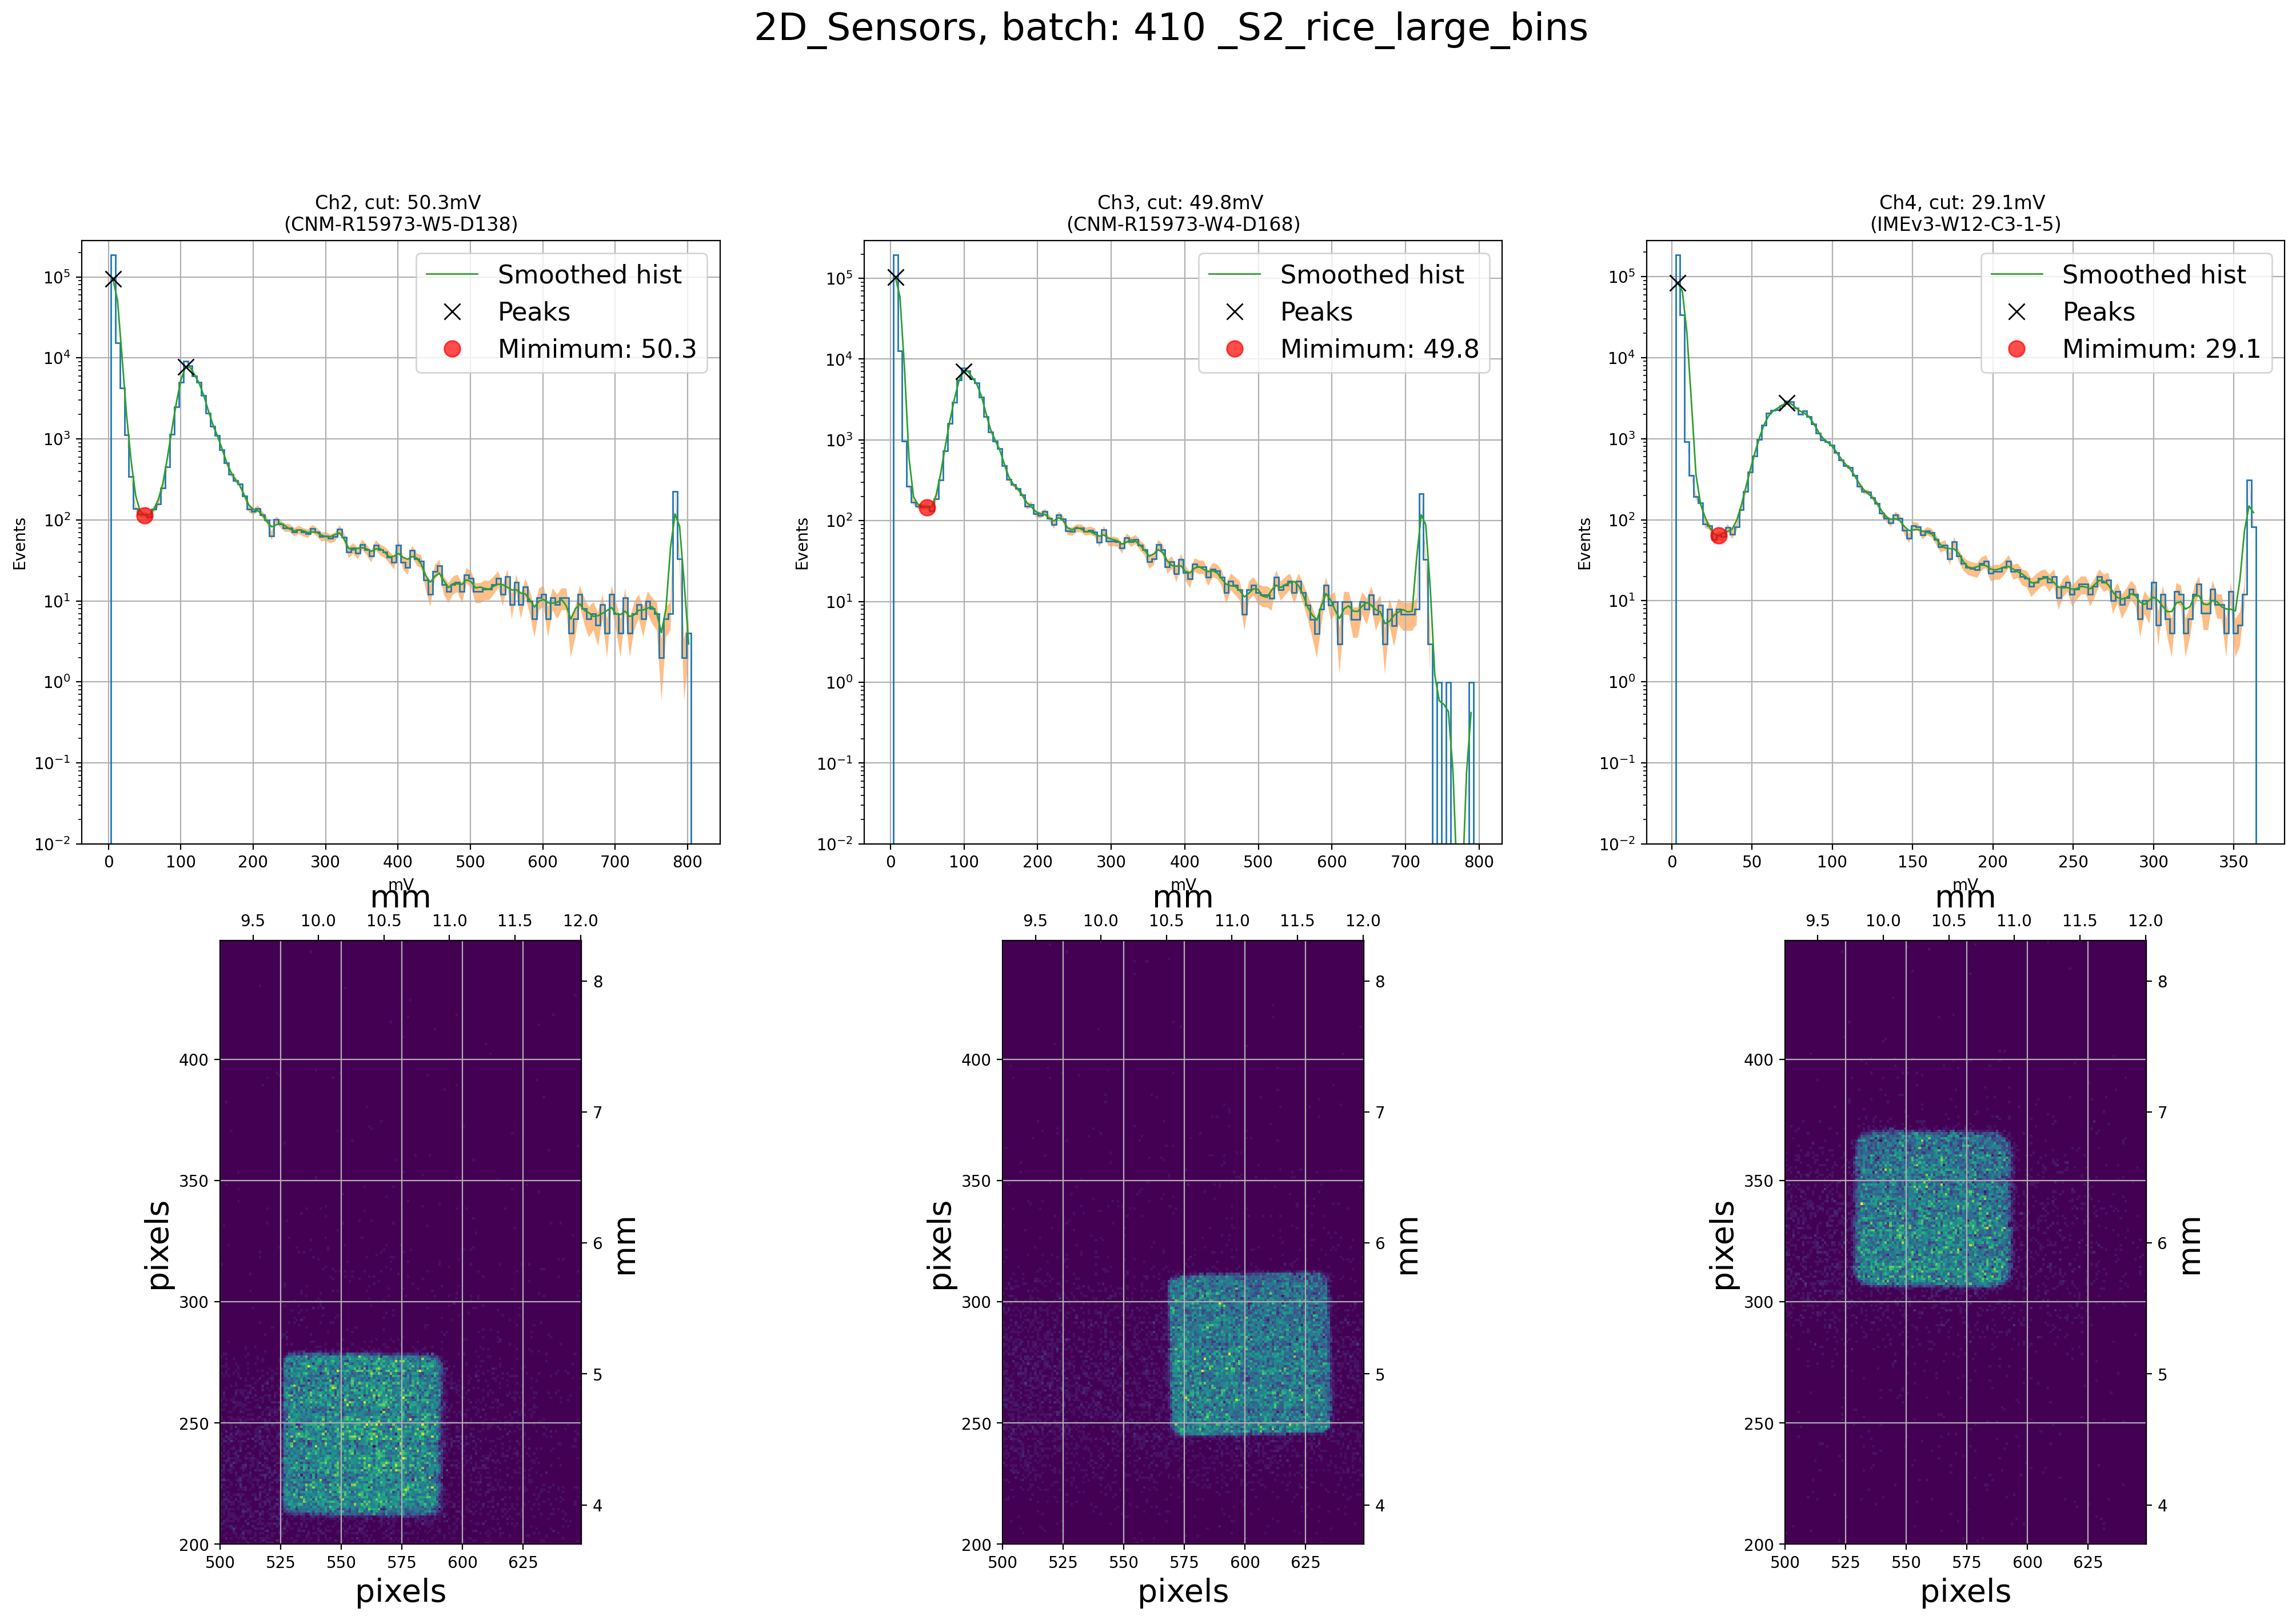

In [5]:
transimpedance = 4700 #ohm

this_batch = 410
print("Batch: ", this_batch)
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
method = 'rice'
for S in ["S1","S2"]: # the two scopes
    print(S)
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"    
    df[S] = root_to_df(os.path.join(dir_path[S], file_path), branches)
    df[S] = df[S].drop(columns=columns_to_remove)
#     plot(df[S], "1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
#      savefig=False, savefig_details=f'_{S}')
    plot(df[S], "2D_Sensors", this_batch, sensors=sensors_list[this_batch][S], bins=small_bins, bins_find_min=method,
    savefig=False, savefig_details=f'_{S}_{method}_large_bins')
    # plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins,
    #     savefig=True, savefig_details='_S2')

## PLOT ALL BATCHES (might be slow, can be done in parts)

In [6]:
### SAVE THE PLOTS FOR ALL BATCHES
binning_method = 'rice'
RUN_ALL_BATCHES = False  ### so I don't accidentally run this
if RUN_ALL_BATCHES:
    for S in ["S1","S2"]: ### the two scopes
        if S=="S1": continue
        for this_batch in np.sort(list(dict_of_runs[S].keys())):  ### I sort them so I can restart from the batch I want
            if this_batch>=407 and this_batch<=500:
                print("Batch: ", this_batch)
                dir_path = f"../Data_TestBeam/2023_May/{S}/"
                file_path = f"tree_May2023_{S}_{this_batch}.root"    
                try:
                    df = root_to_df(os.path.join(dir_path, file_path), branches)
                except:
                    print("something wrong reading the file")
                    continue
                df = df.drop(columns=columns_to_remove)
        #         plot(df,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #              savefig=True, savefig_details=f'_{S}')
    #             plot(df,"1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=large_bins,
    #                  savefig=True, savefig_details=f'_{S}')
        #         bins = 1000
        #         plot(df, "pulseHeight", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
        #             savefig=True, savefig_details=f"_{S}_bins_{bins}")
                plot(df, '2D_Sensors', batch=this_batch, sensors=sensors_list[this_batch][S],
                     bins=large_bins, bins_find_min=binning_method, savefig=False, savefig_details=f'_{S}_large_bins')#_{binning_method}')
                
            ### I think something is leaking memory!!!
            plt.close('all') # I think this worked. maybe not actually

## Plot a single run

In [7]:
# ### looking at single runs 
# dir_path = f"../Data_TestBeam/2023_May/S1/"
# run = 9723
# file_path = f"tree00{run}.root"    
# df_run = root_to_df(os.path.join(dir_path, file_path), branches)
# df_run = df_run.drop(columns=columns_to_remove)
    
# plot(df_run,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins,
#     savefig=True, savefig_details=f"_single_run_{run}")
# # plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

## Improved efficiency study

In [8]:
this_scope = "S1"
fig, axes = plot(df[this_scope], "1D_Efficiency", this_batch, bins=small_bins, threshold_charge=2, no_geometry_cut=False,
                 transimpedance=10700, savefig=False, savefig_details='charge: 2fC')
for ax in axes.flatten():
    ax.grid('--')

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
fig

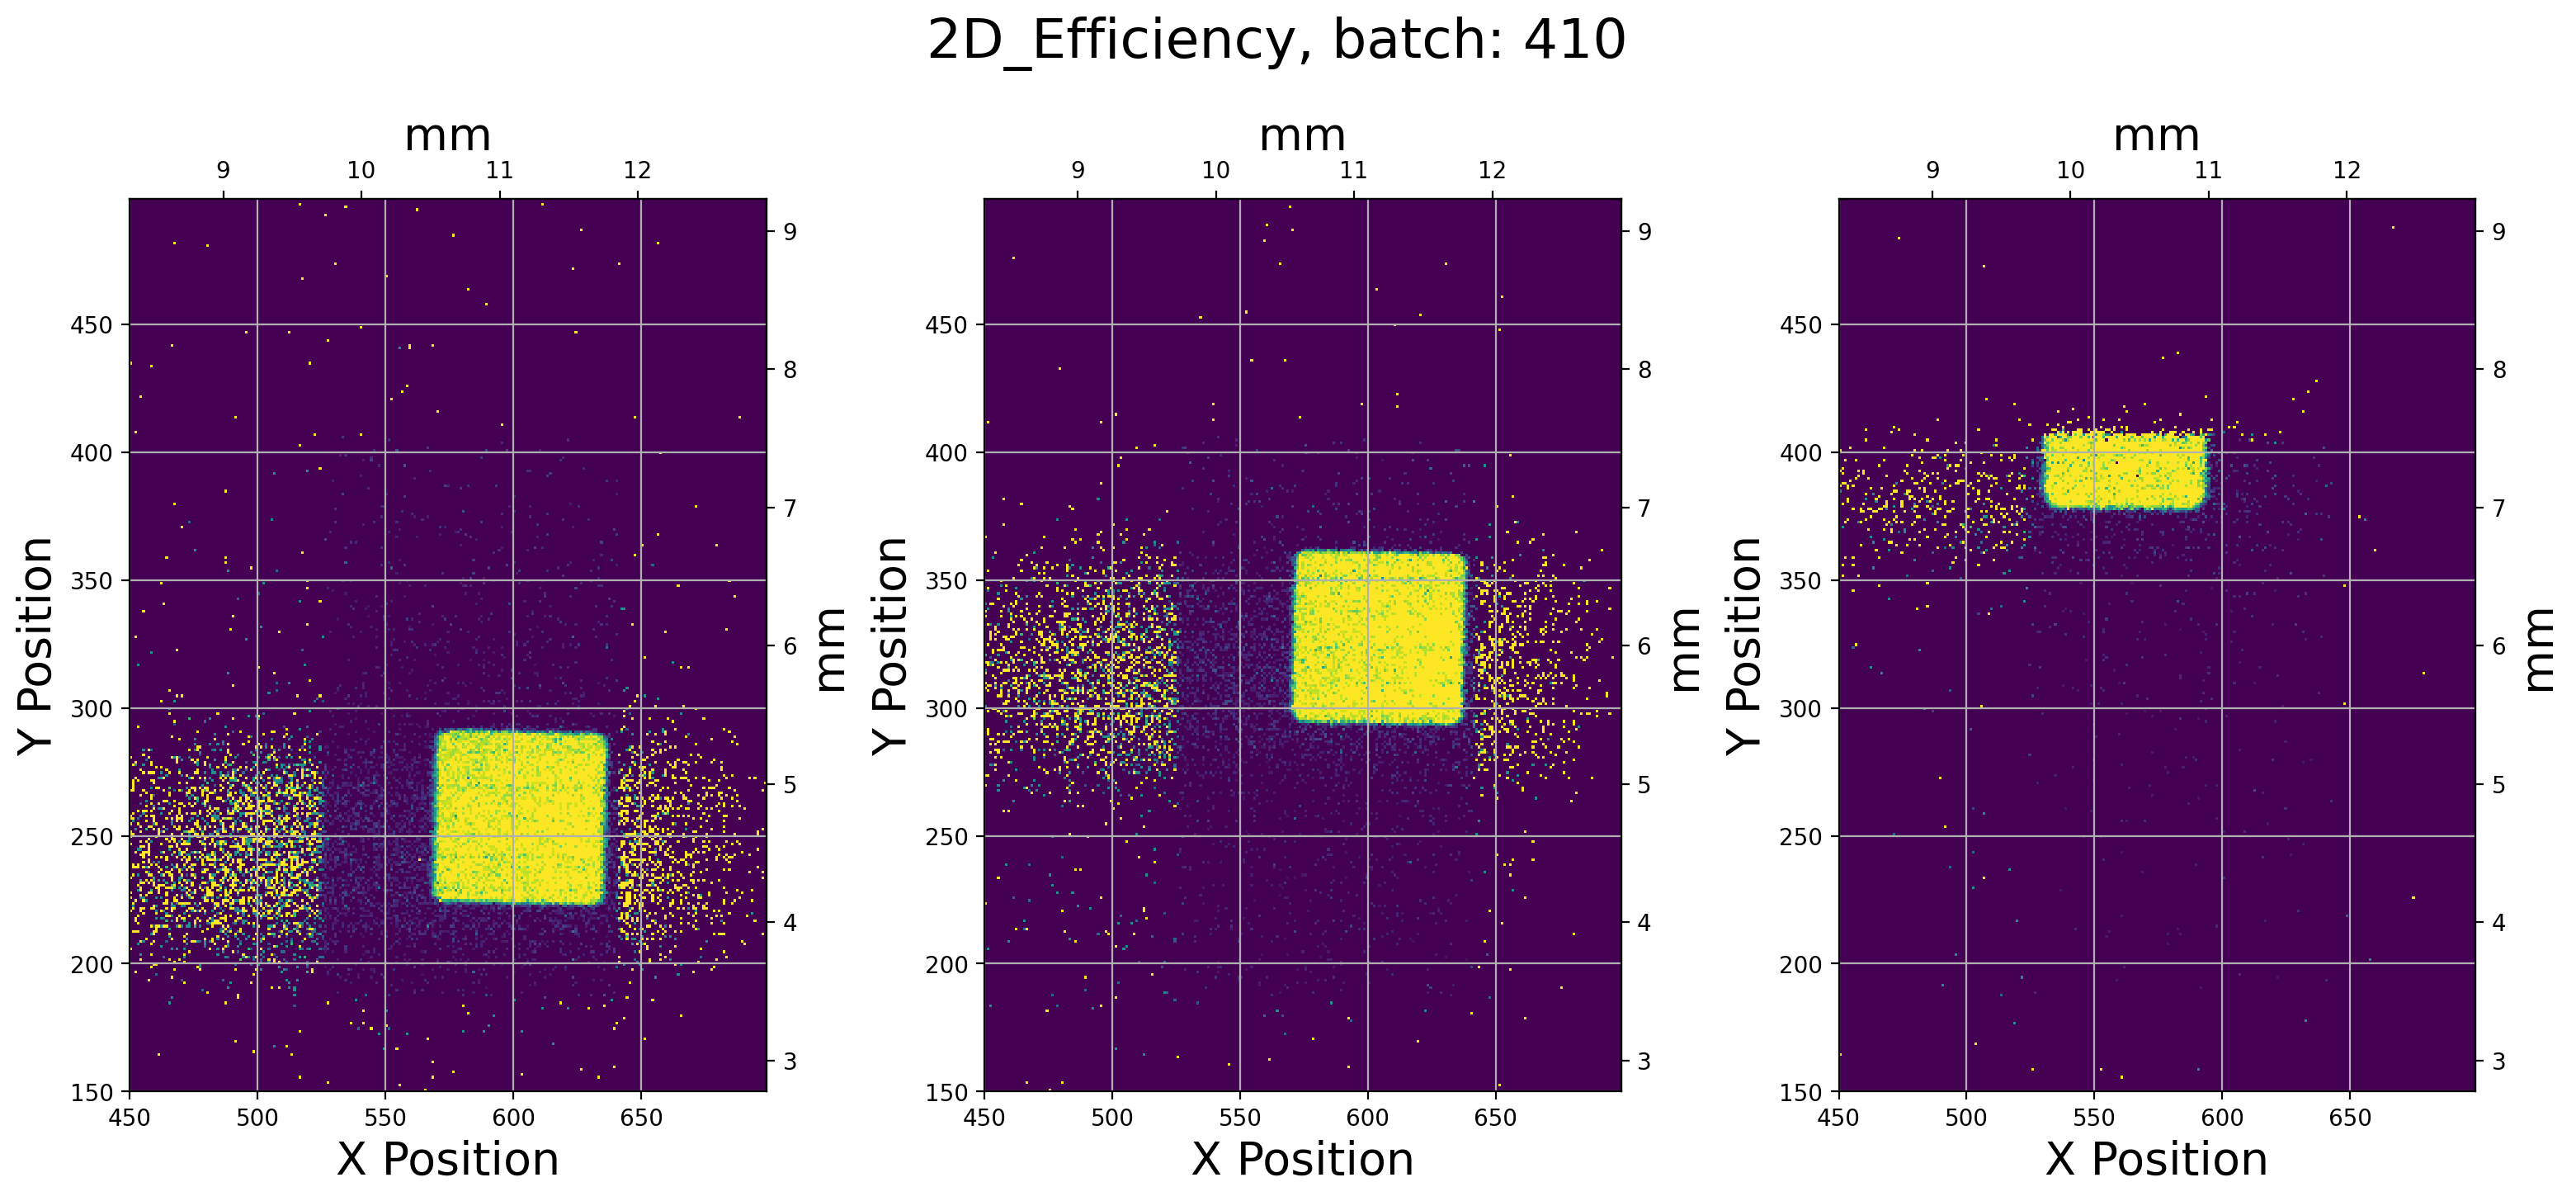

In [13]:
fig, axes = plot(df[this_scope], "2D_Efficiency", this_batch, bins=bins, threshold_charge=2, no_geometry_cut=True,
                 transimpedance=10700, savefig=False)

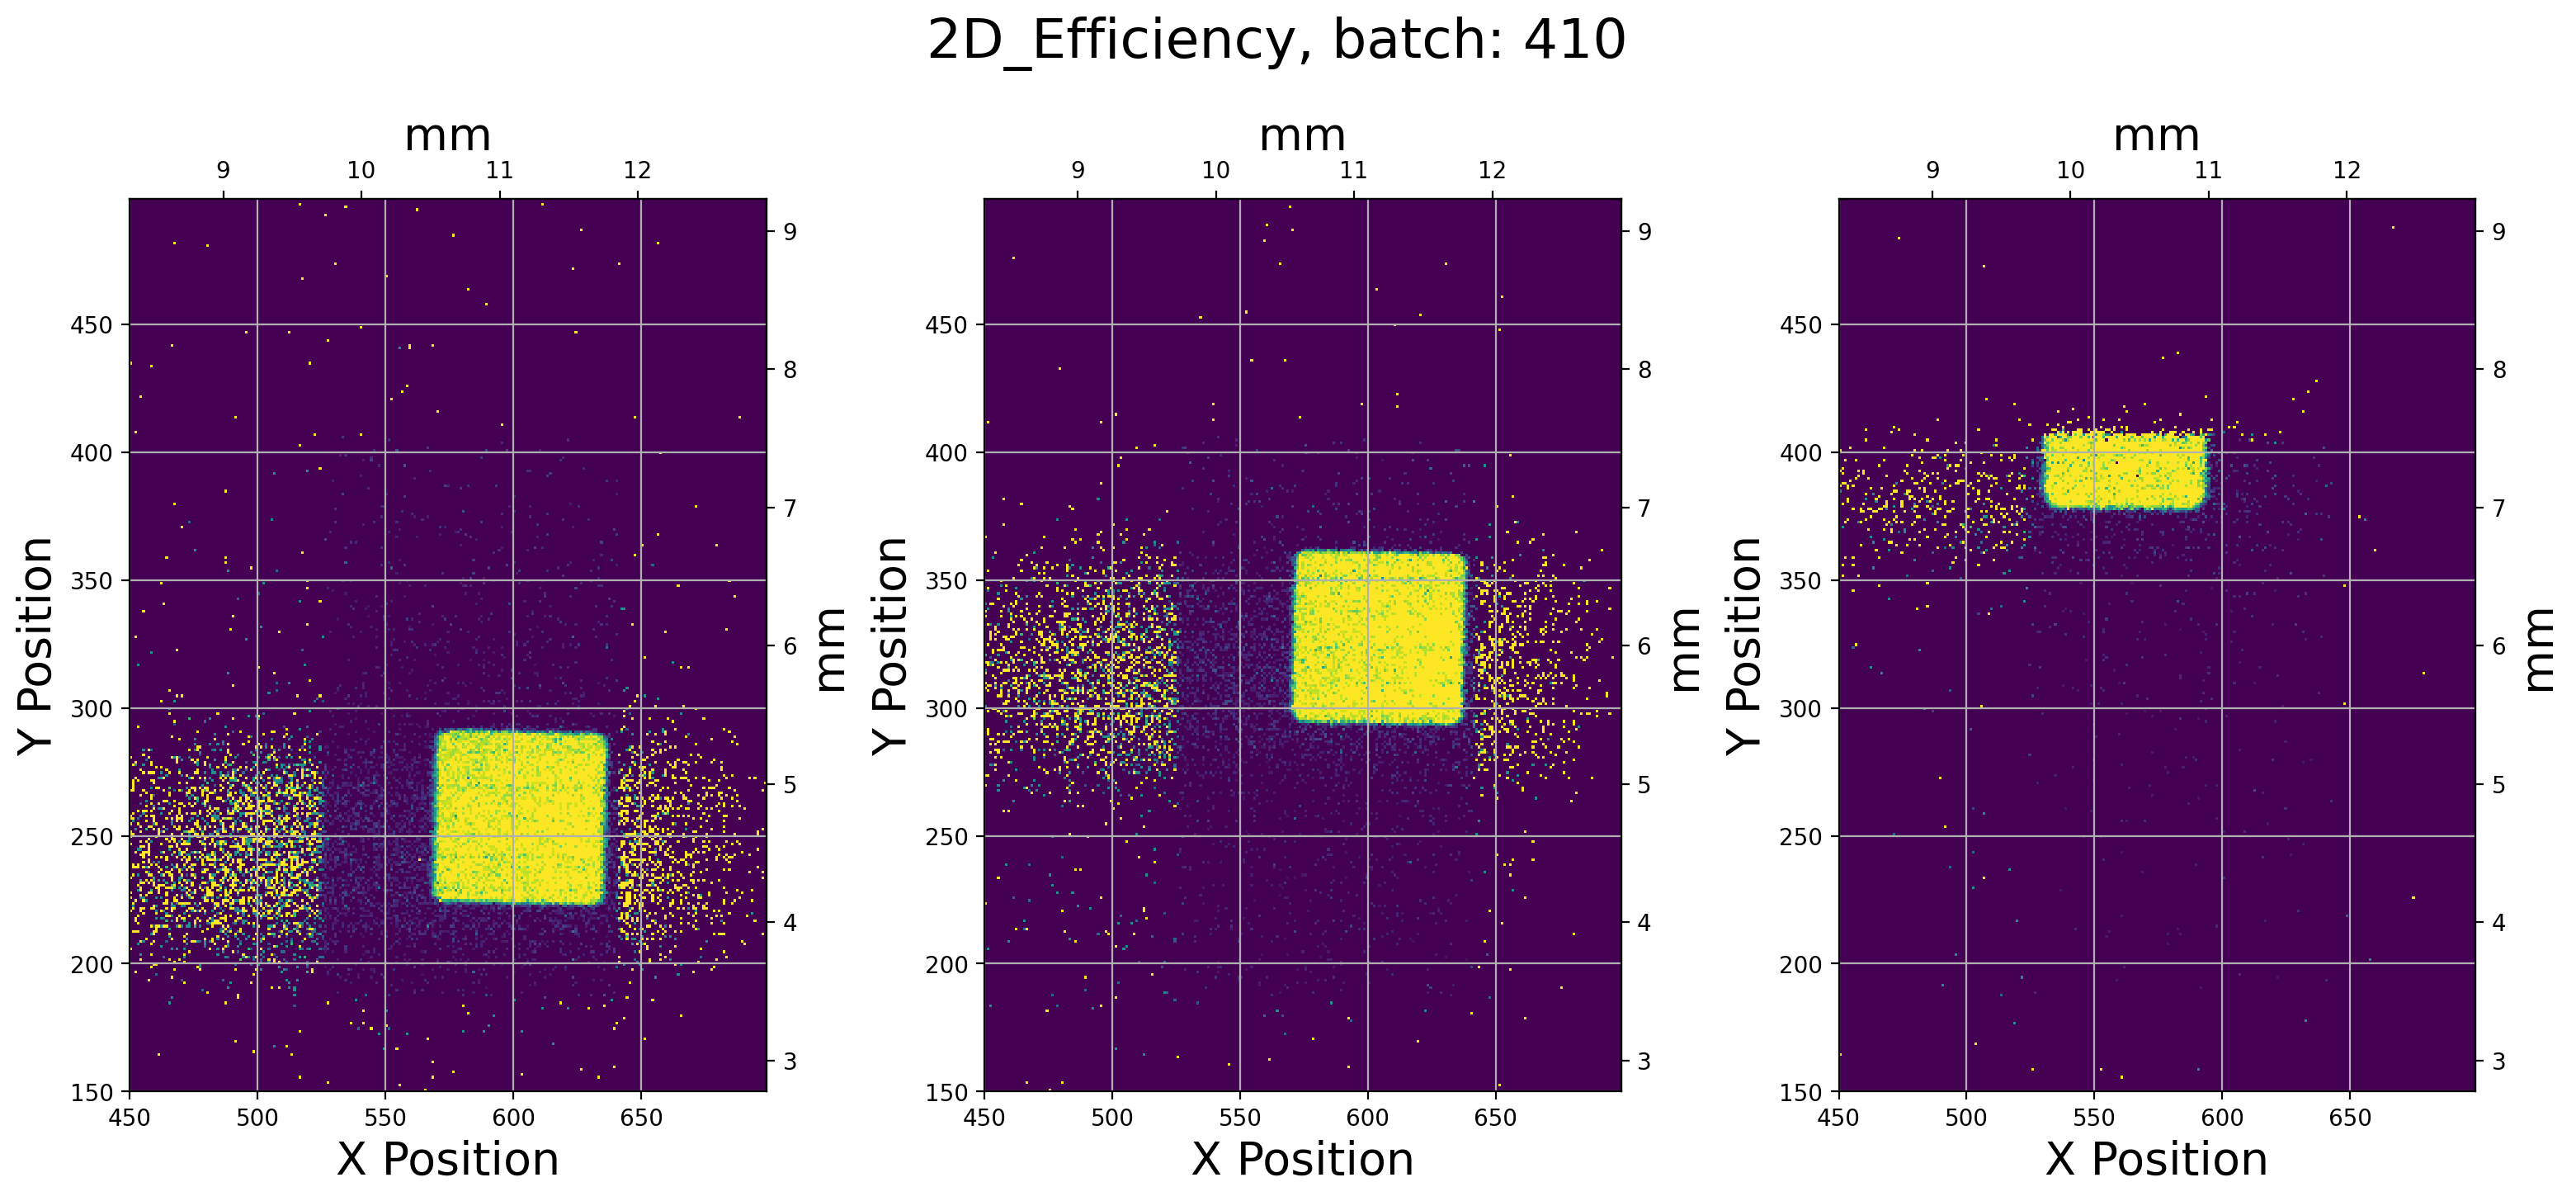

In [14]:
fig 

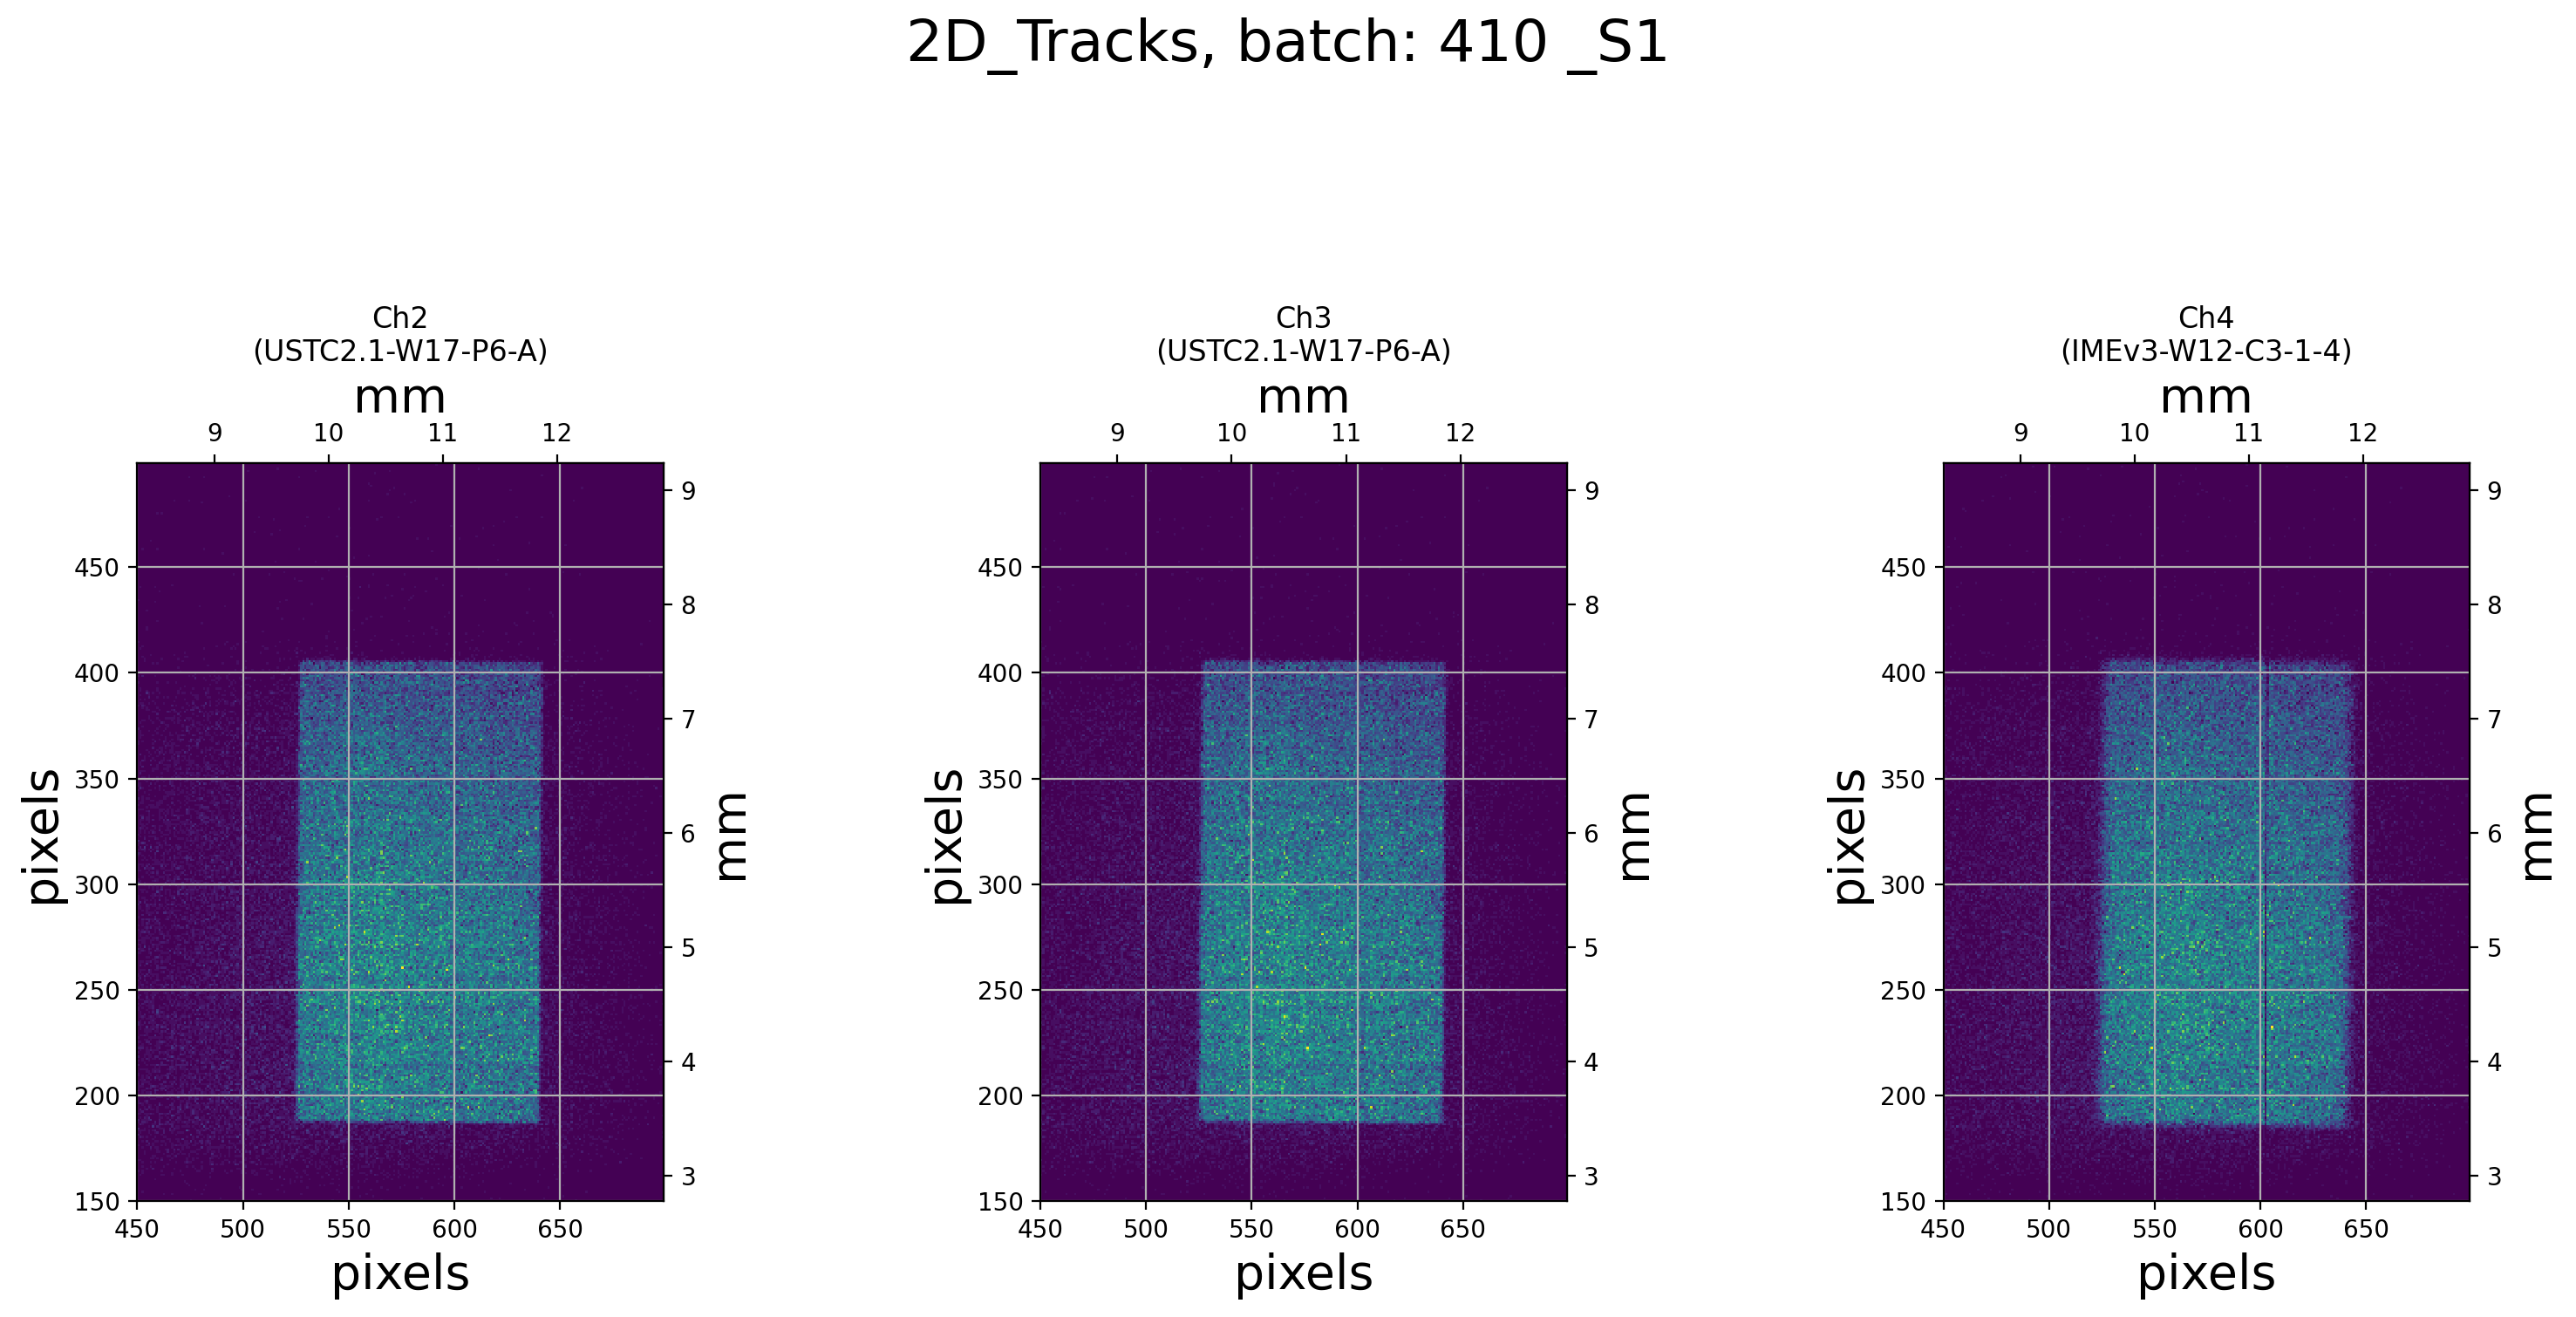

(<Figure size 3000x1200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch4\n(IMEv3-W12-C3-1-4)'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [10]:
S = "S1"
plot(df[S],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
     savefig=True, savefig_details=f'_{S}')

In [ ]:
# left_edge, right_edge = find_edges(Xtr_1cut)

# fig, ax = plt.subplots(figsize=(15,8))
# hist, bins, _ = plt.hist(Xtr_1cut, bins=bins[0], histtype='step')#, label=f'Xtr sensor: {these_sensors[1]}')
# ax.plot((bins[:-1]+bins[1:])/2, np.gradient(hist), label='gradient of Xtr')
# ax.axvline(left_edge, color='g', linestyle='--', label='left edge')
# ax.axvline(right_edge, color='r', linestyle='--', label='right edge')
# # ax.set_title(f"Xtr_1 distribution of {these_sensors[1]} (with pulseheight cut)", fontsize=24, y=1.05)
# ax.set_xlim(400,900)
# ax.set_xlabel("Position (pixels)", fontsize=20)
# ax.set_ylabel("Events", fontsize=20)
# ax.grid('--')
# ax.legend(fontsize=20, loc='upper left')

# # fig.savefig(f"various plots/locating_edges_Xtr_of_{these_sensors[1]}.jpg")

array([ 82510., 110840.,  53411.])

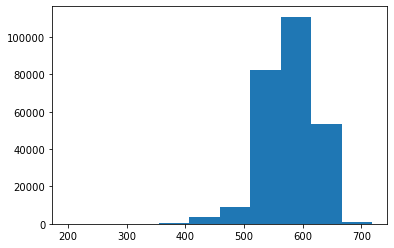

In [10]:
hist, bins, _ = plt.hist(df["S1"]["Xtr_0"])


In [1]:
mins = {}
for S in ["S1","S2"]:
    mins[S] = [find_min_btw_peaks(df[S][f"pulseHeight_{i}"], bins='rice', plot=False) for i in range(1,4)]
    mins[S].insert(0,None)     ### insert None as the 'peak' of the MCP

NameError: name 'find_min_btw_peaks' is not defined

### Charge plot with different cuts
(for one DUT)

In [ ]:
# mins = {"S1":[0,53.8,52.1,65.3], "S2":[0,37.9,51.6,64.3]}
this_scope = "S1"
this_DUT = 2 ### 1,2,3
transimpedance = 4700

pulseheight_cut = df[this_scope][f"pulseHeight_{this_DUT}"]>mins[this_scope][this_DUT]
geometry_cut = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice', DUT_number=this_DUT)

data_pulse_filter = df[this_scope][f"charge_{this_DUT}"].loc[pulseheight_cut]/transimpedance
data_pulse_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[np.logical_and(pulseheight_cut, geometry_cut)]/transimpedance
data_geo_filter = df[this_scope][f"charge_{this_DUT}"].loc[geometry_cut]/transimpedance

# I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _,_,_ = plot_histogram(df[this_scope][f"charge_{this_DUT}"]/transimpedance, bins='auto', label="no cut", fig_ax=(fig,ax), alpha=.5, color='#0000ff')
plot_histogram(data_pulse_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight cut", alpha=.5, color='#00ff00')
plot_histogram(data_pulse_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
plot_histogram(data_geo_filter, bins=bins_for_all, fig_ax=(fig,ax), label="geometry cut", alpha=.5, color='#505050') # #ffff00
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot various cuts \nbatch:{this_batch}, {this_scope}, DUT:{this_DUT} ({sensors_list[this_batch][this_scope][f'Ch{this_DUT+1}']})",
             fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,50)
ax.semilogy()
ax.legend(fontsize=16)

# fig.savefig(f"various plots/charge_plot_various_cuts_{this_batch}_{this_scope}_DUT{this_DUT}.jpg")

In [ ]:

sensors_list[this_batch][this_scope]['Ch2']

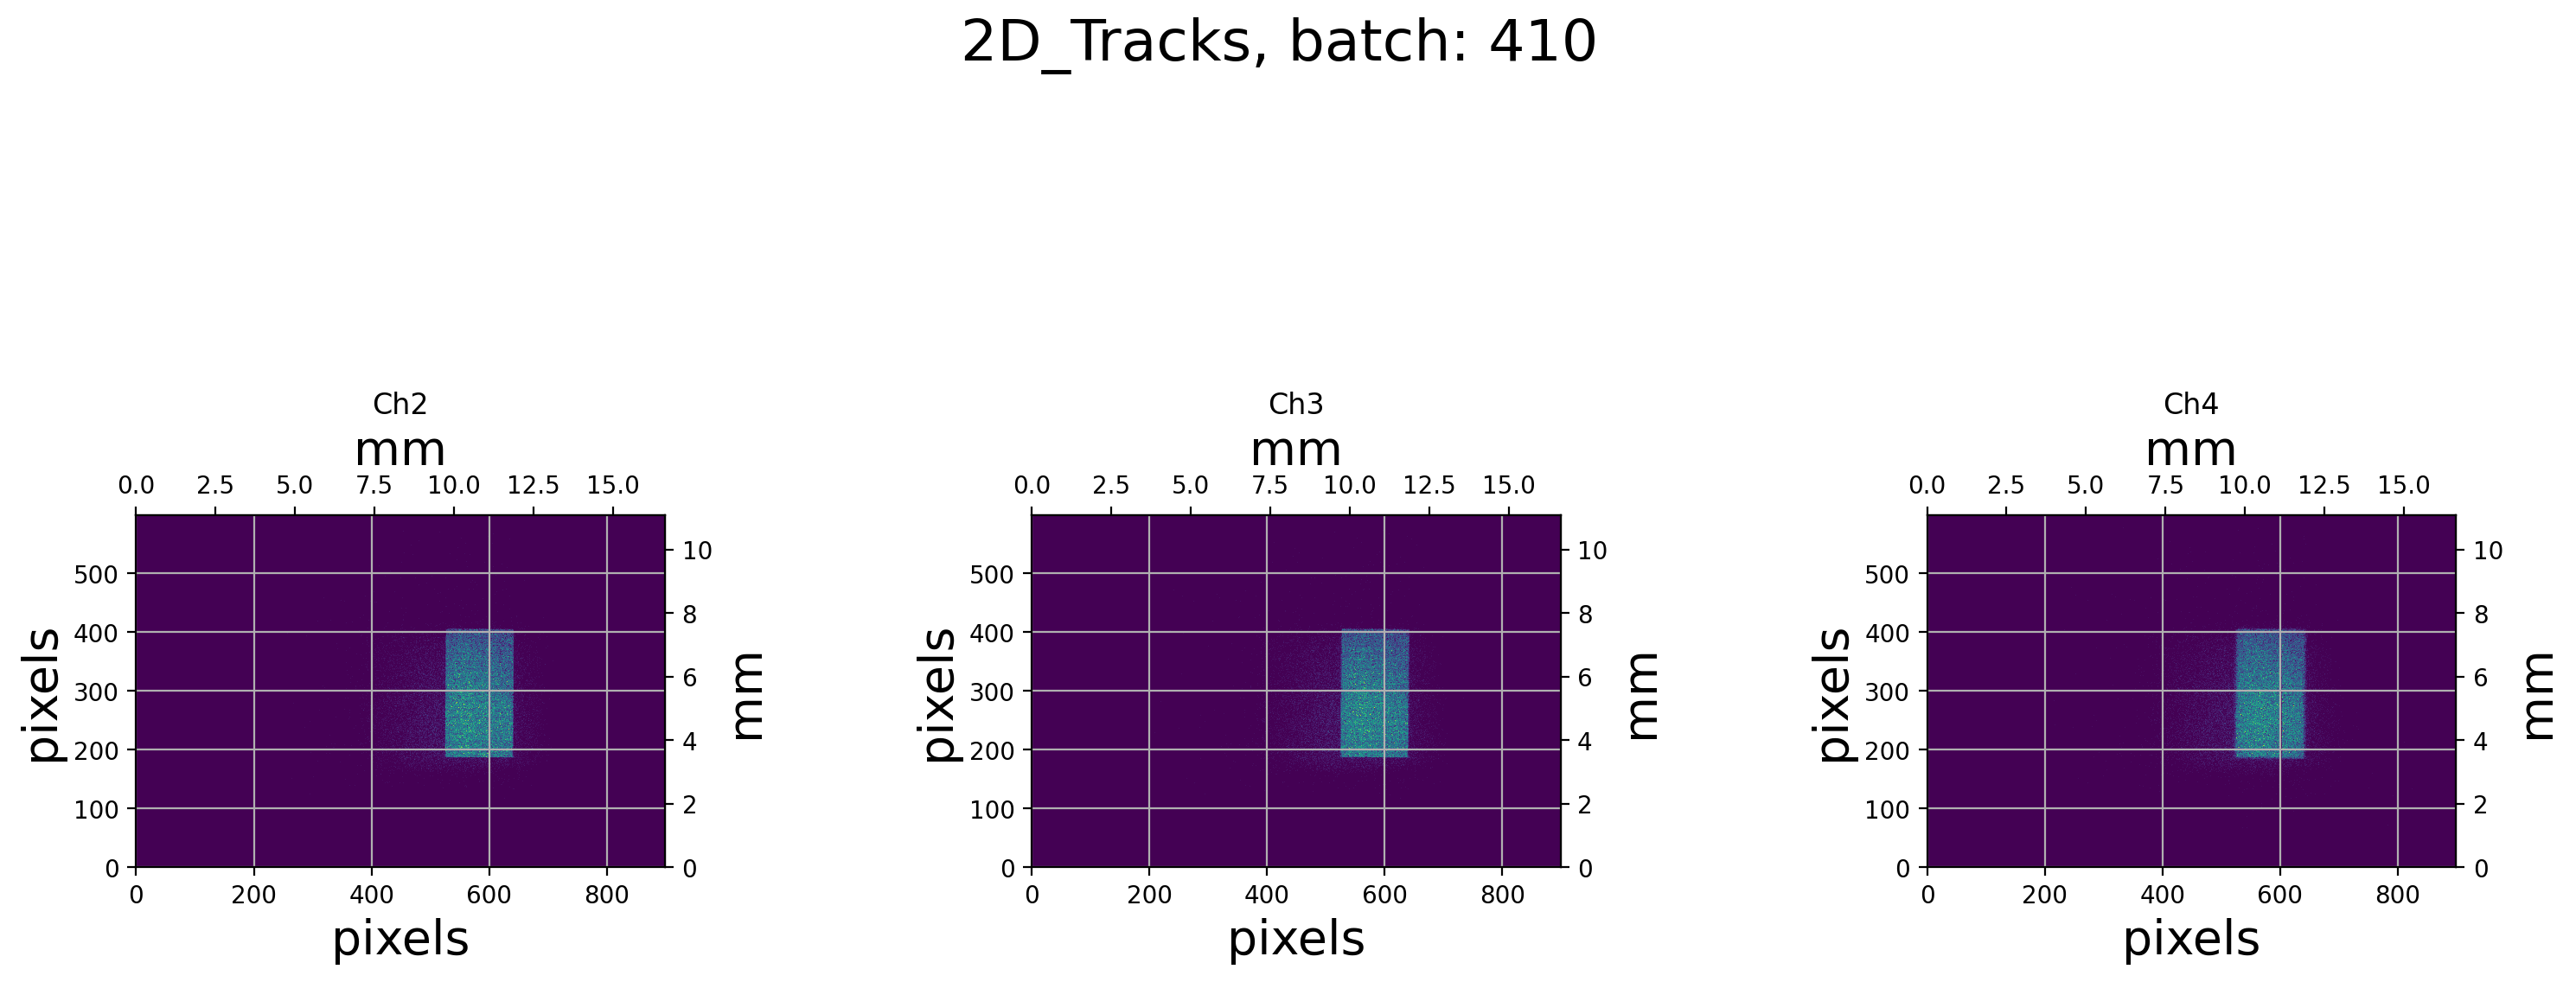

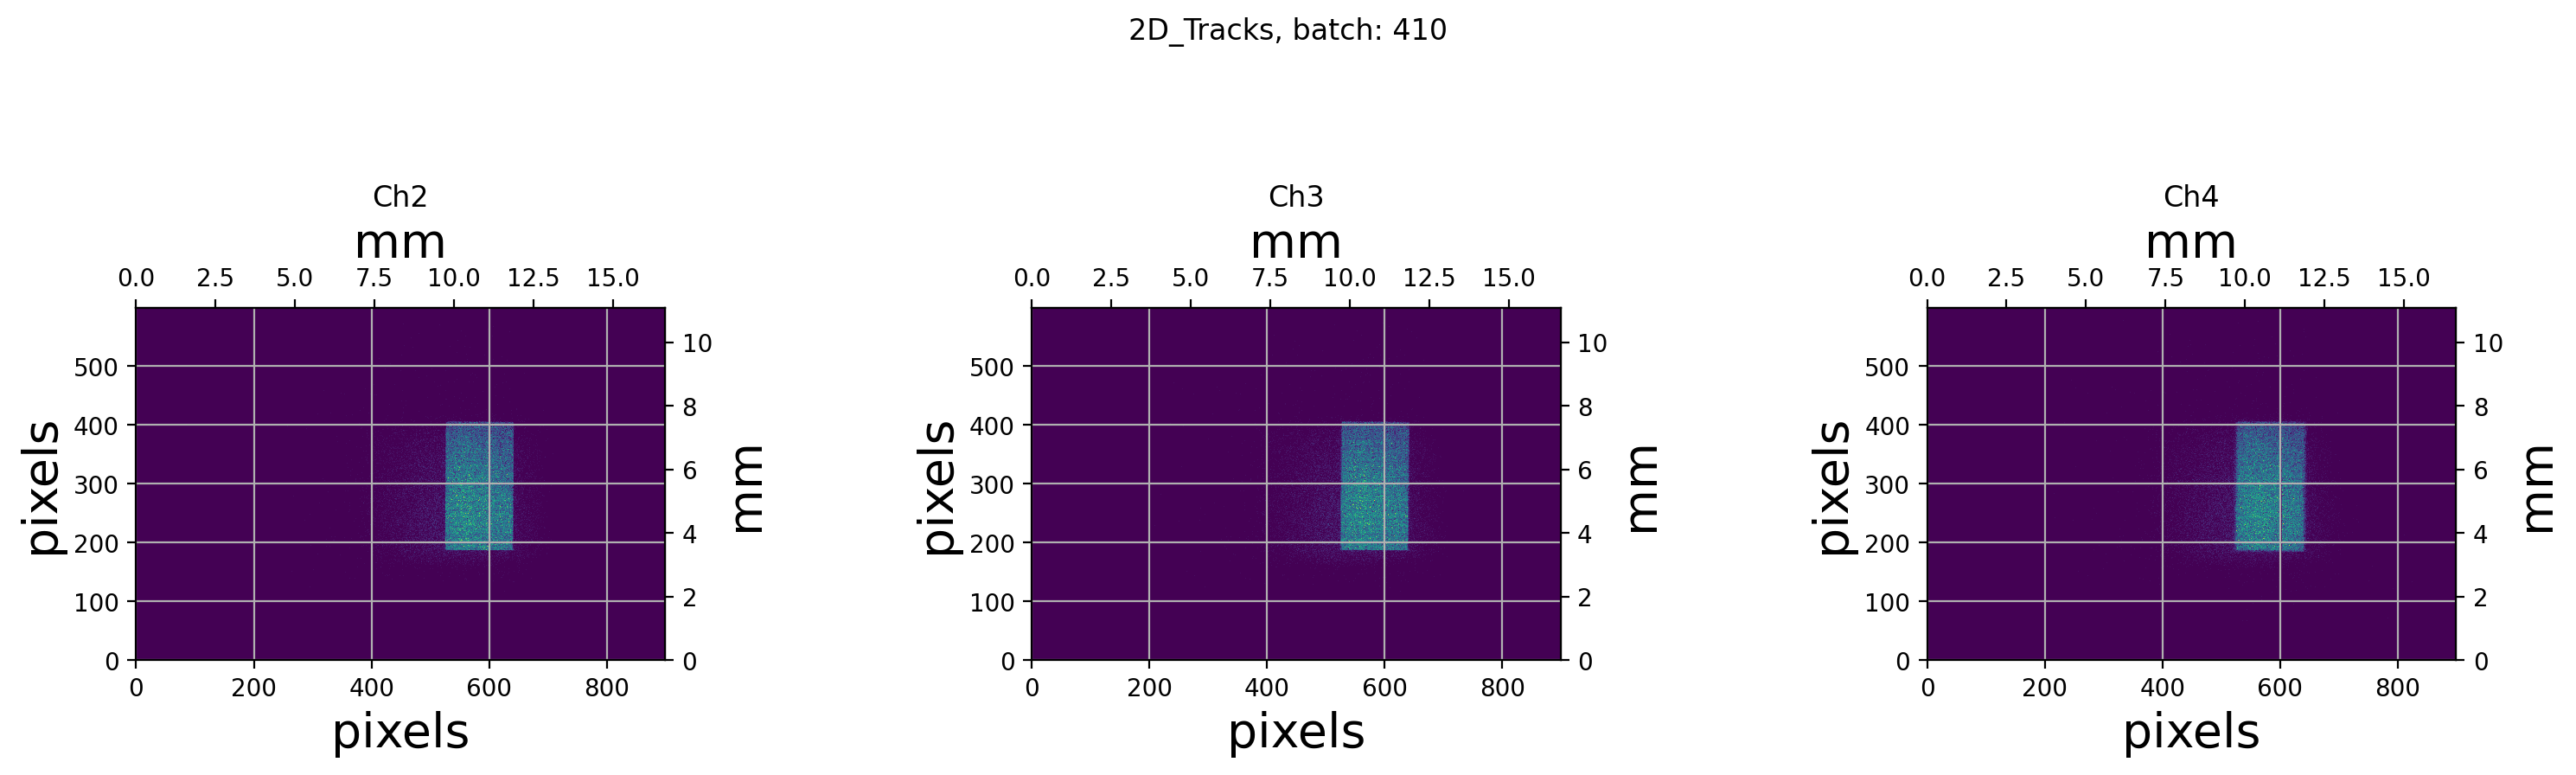

In [27]:
# fig, ax = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300, sharex='all')
# fig.tight_layout(w_pad=4)

# Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
# Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
# ax[0].hist2d(Xtr_1, Ytr_1, bins=bins)
# ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")
# ax[0].set_aspect('equal')

# Xtr_2 = df[this_scope]["Xtr_2"]#*pixel_size
# Ytr_2 = df[this_scope]["Ytr_2"]#*pixel_size
# ax[1].hist2d(Xtr_2, Ytr_2, bins=bins)
# ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")
# ax[1].set_aspect('equal')
fig, ax = plot(df["S1"], "2D_Tracks",batch=this_batch, bins=large_bins)
fig.suptitle("2D_Tracks, batch: 410", y=0.95)
fig

## Efficiency Study

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


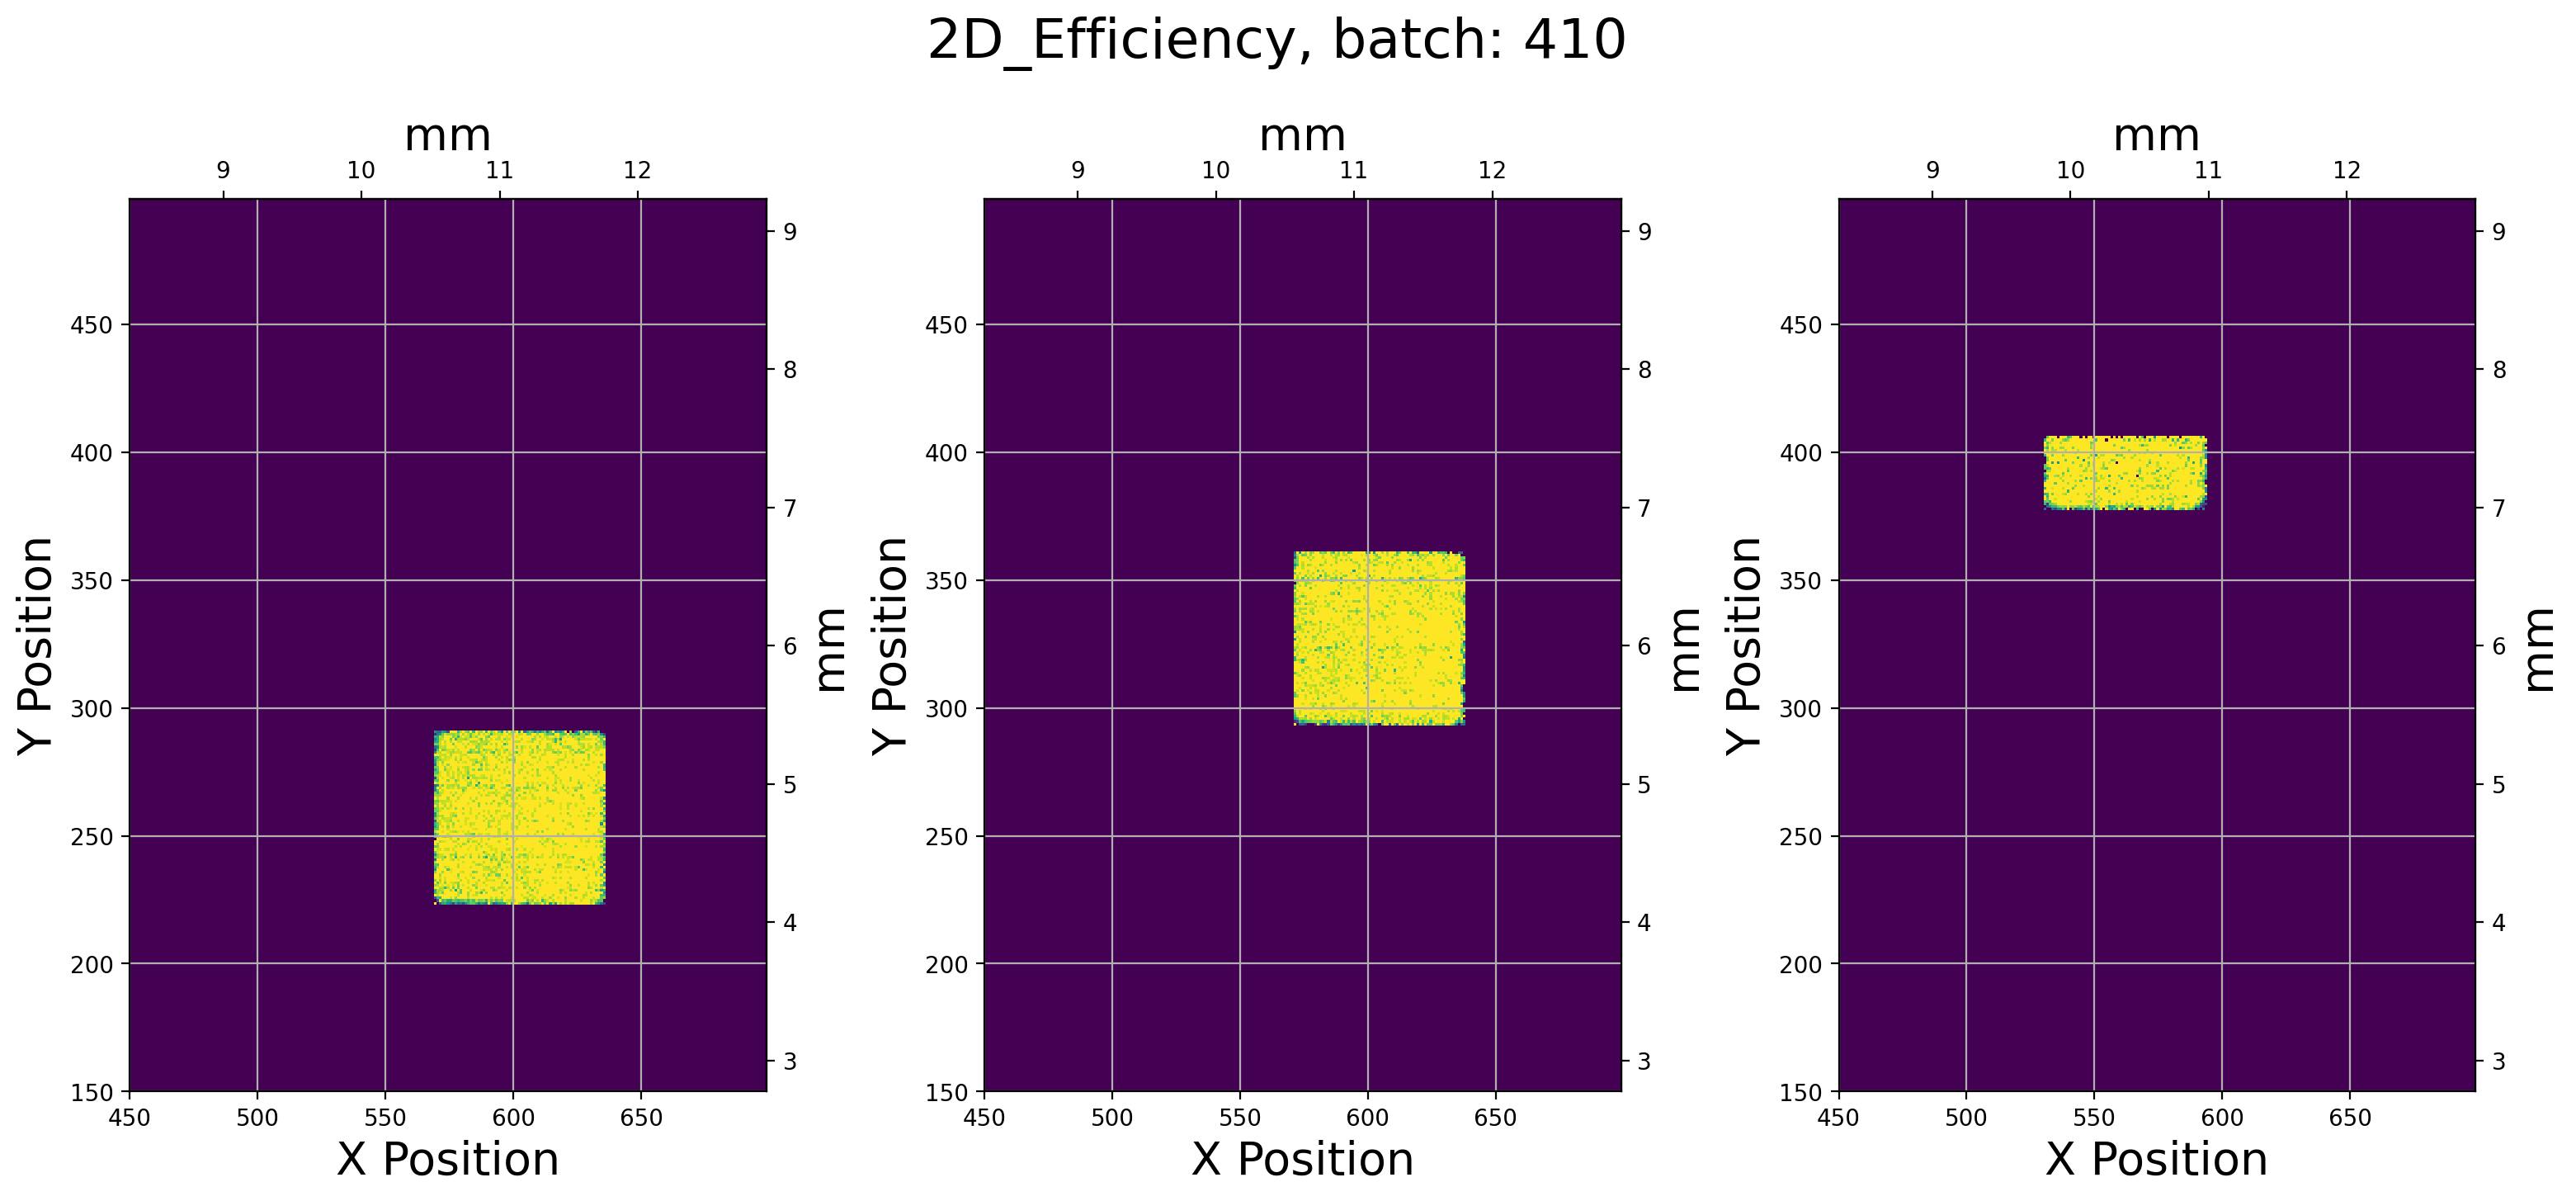

In [16]:
### efficiency study
threshold_charge = 2 #fC
transimpedance = 4700 

fig,axes = plot(df[this_scope], "2D_Efficiency", this_batch,bins=bins, large_edges=False,
                sensors=sensors_list[this_batch][this_scope], threshold_charge=threshold_charge, transimpedance=transimpedance)
fig

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


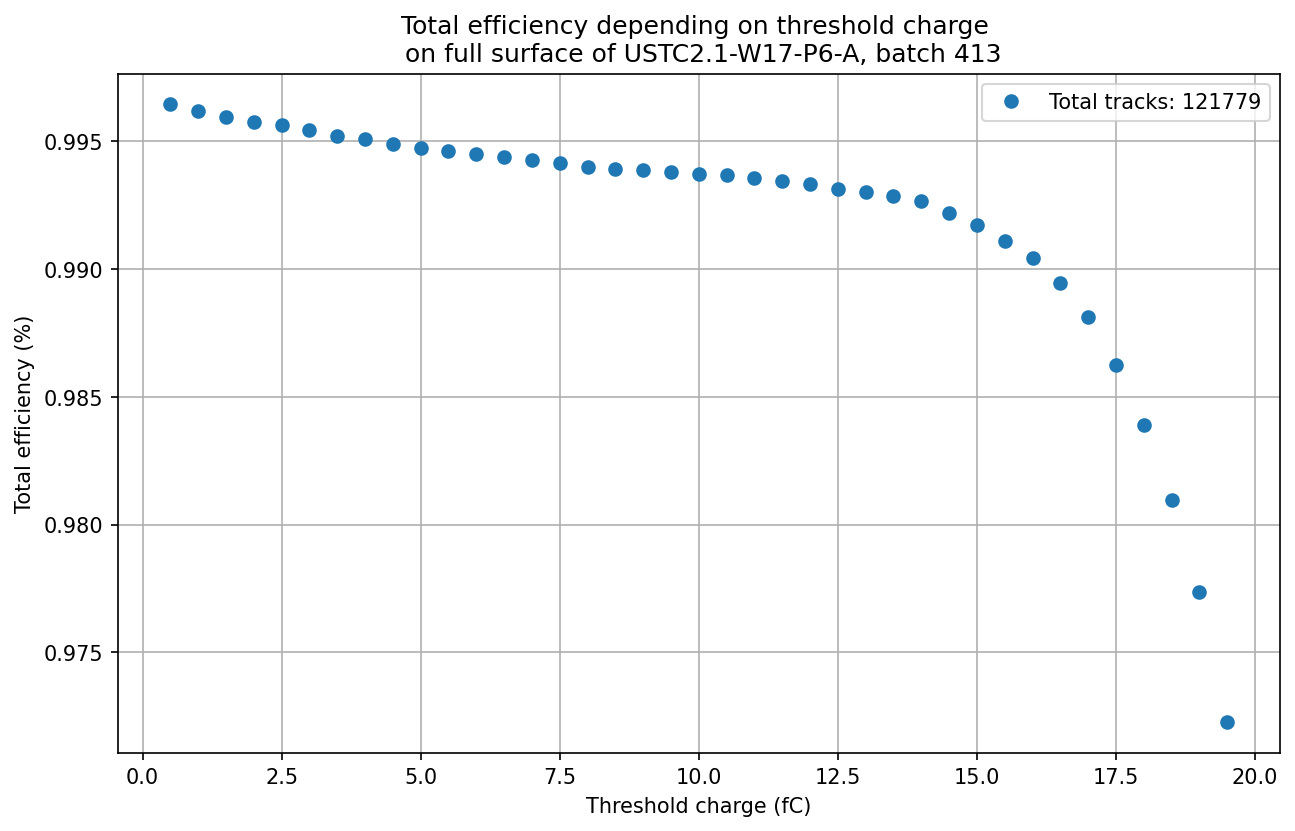

In [15]:
# total efficiency with pulseHeight_cut
transimpedance = 4700 # 10700
efficiency_range = []
threshold_range = np.arange(0.5, 20, 0.5)
geometry_1 = geometry_mask(df[this_scope], bins=bins, bins_find_min='rice',DUT_number=1)
pulseHeight_1 = df[this_scope]["pulseHeight_1"]>mins[this_scope][1]
for charge in threshold_range:
    efficiency_range.append(efficiency(
        df[this_scope]["charge_1"].loc[np.logical_and(geometry_1,pulseHeight_1)]/transimpedance, charge, percentage=False))

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range,'o', 
        label=f"Total tracks: {df[this_scope]['charge_1'].loc[geometry_1].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {sensors_list[this_batch][this_scope][f'Ch2']}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency (%)")
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/Total_efficiency_change_USTC_{this_batch}.jpg")

## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist
in 'find_edges()': KDE timed out, using normal hist


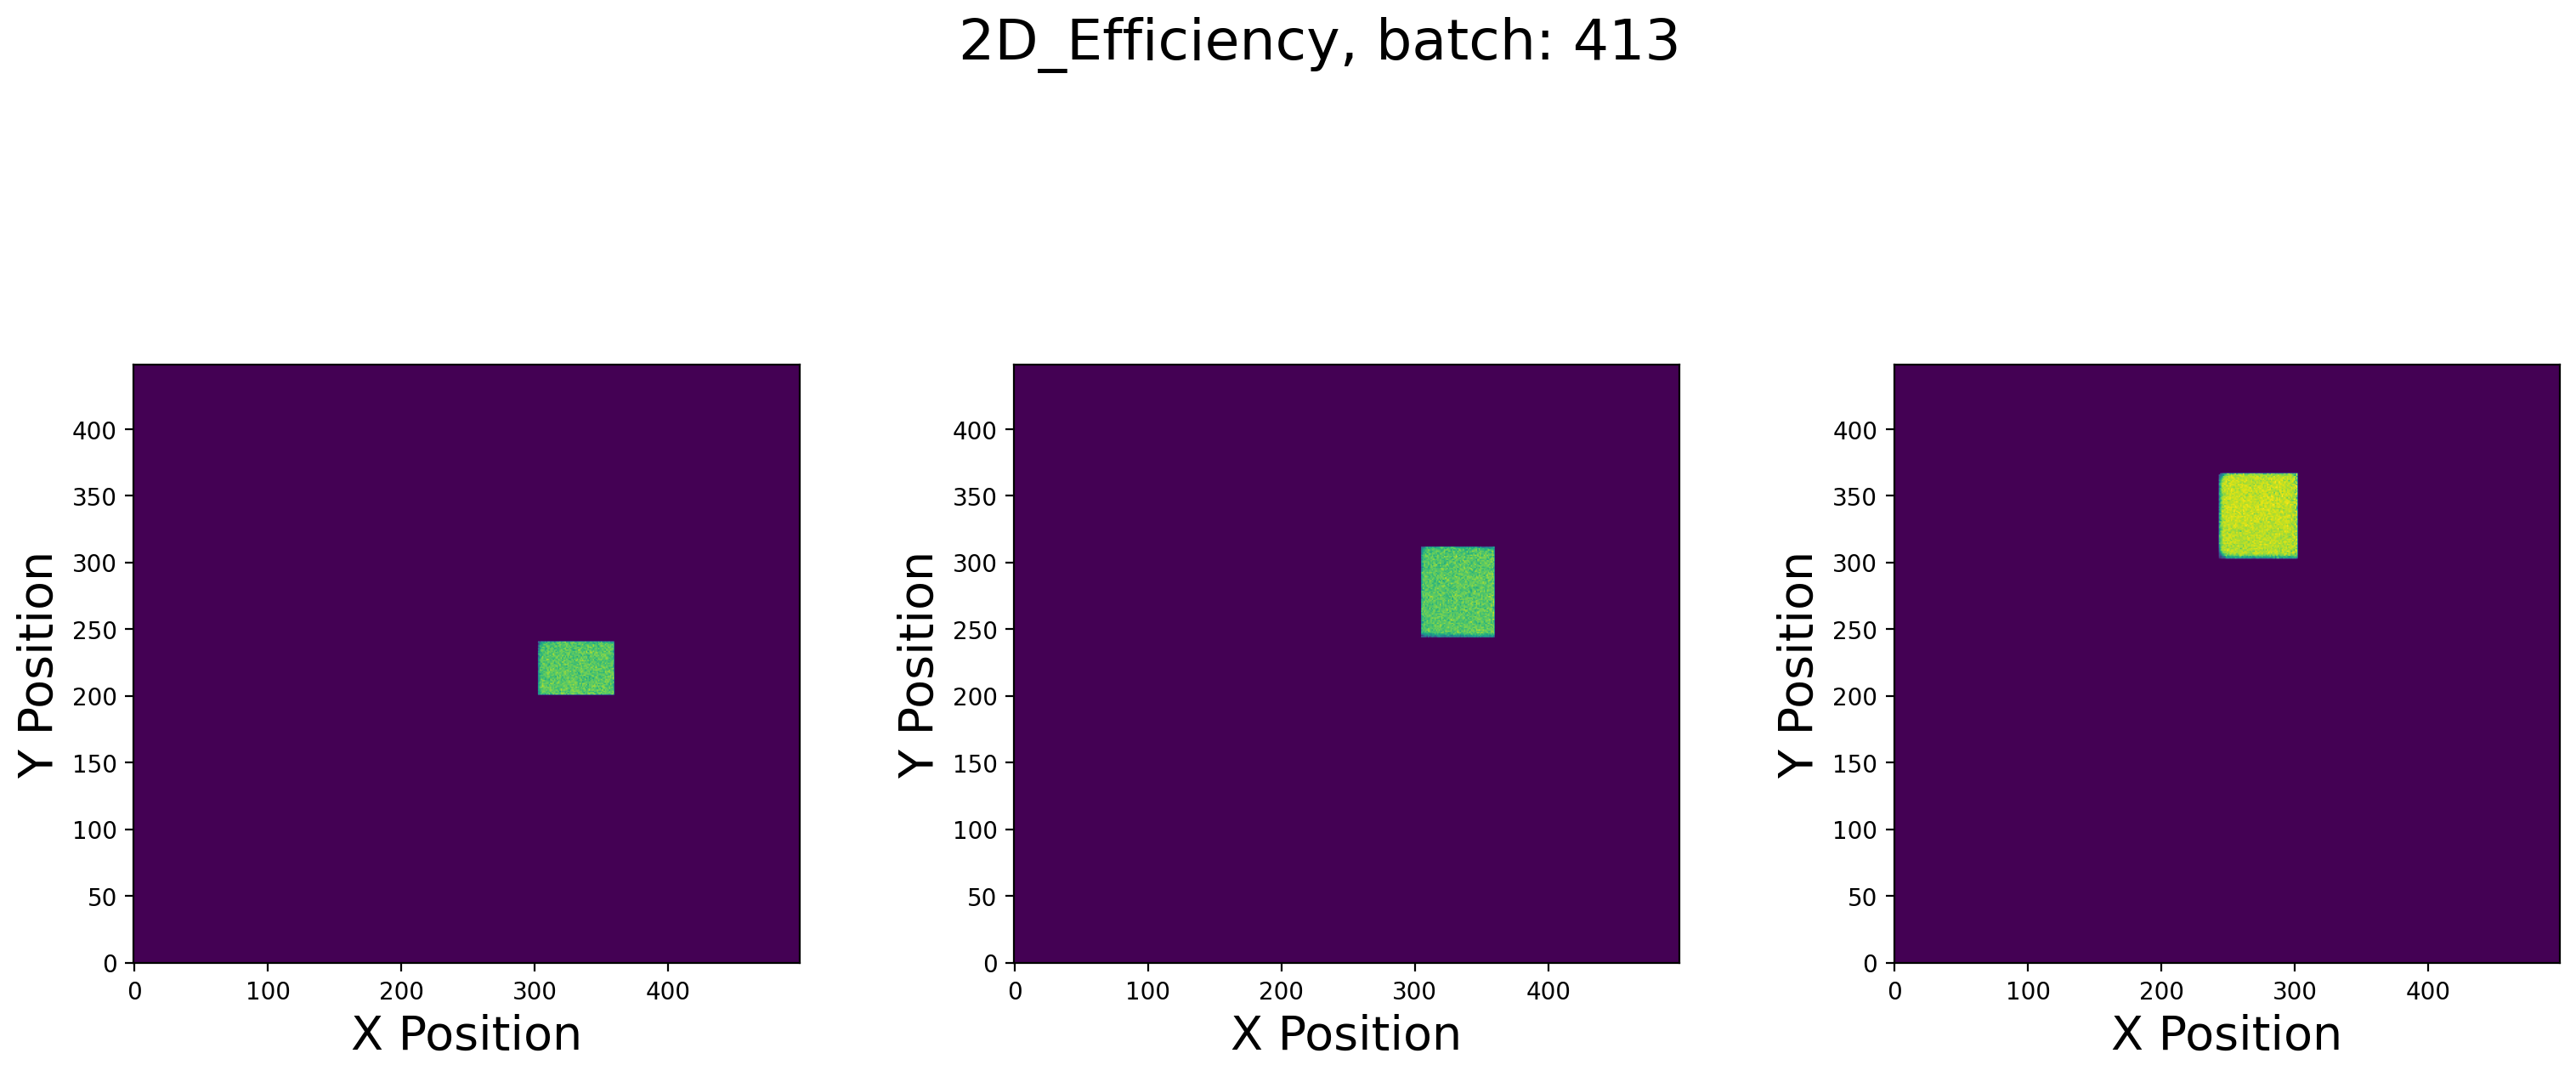

In [13]:
threshold_charge = 2
fig, axes = plot(df[this_scope],"2D_Efficiency", this_batch, bins=small_bins, sensors=sensors_list[this_batch][this_scope],
    transimpedance=transimpedance, threshold_charge=threshold_charge)
fig

In [ ]:
# # efficiency study
# charge_threshold = 2 #fC
# transimpedance = 4700 
# bins = (int(new_width_pixel), int(new_width_pixel))

# total_events_in_bin, x_edges_small, y_edges_small,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1)],
#                                                     df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1)],
#                                                      bins=bins)#, range=(x_lim.values(), y_lim.values()))

# # Create a boolean mask for events above the threshold
# events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance > charge_threshold

#  # Calculate the number of events above threshold in each bin
# events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
#                                                     df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
#                                                     bins=(x_edges_small, y_edges_small))
# # plt.set_aspect('equal')
# plt.close()

# # Calculate the efficiency for each bin
# efficiency_map_small = np.divide(events_above_threshold_in_bin, total_events_in_bin,
#                            where=total_events_in_bin!=0,
#                            out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [ ]:
# edges_central["Ch2"]["left"]

In [95]:
# fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300)#, gridspec_kw={'width_ratios':[5,5,1]})

# im = axes[0].imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
#            aspect='equal', vmin=0, vmax=100)

# # rect = mpatches.Rectangle((edges_central["Ch2"]["left"], edges_central["Ch2"]["bottom"]), new_width_pixel, new_width_pixel,
# #                           linewidth=1, edgecolor='r', facecolor='none') # small 
# # axes[0].add_patch(rect)
# # ax[0].colorbar(label='Efficiency')
# axes[0].set_xlabel('X Position (pixel)', fontsize=20)
# axes[0].set_ylabel('Y Position (pixel)', fontsize=20)
# secx = axes[0].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
# secy = axes[0].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
# secx.set_xlabel('mm', fontsize=20)
# secy.set_ylabel('mm', fontsize=20)

# axes[1].imshow(efficiency_map_small.T, origin='lower', extent=[x_edges_small[0], x_edges_small[-1], y_edges_small[0], y_edges_small[-1]],
#            aspect='equal', vmin=0, vmax=100)
# axes[1].set_xlabel('X Position (pixel)', fontsize=20)
# axes[1].set_ylabel('Y Position (pixel)', fontsize=20)
# secx = axes[1].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
# secy = axes[1].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
# secx.set_xlabel('mm', fontsize=20)
# secy.set_ylabel('mm', fontsize=20)

# axes[0].set_aspect('equal')
# axes[1].set_aspect('equal')

# # plt.colorbar(im, cax=axes[2], fraction=1)
# fig.subplots_adjust(right=1)
# # plt.colorbar(im, label="Efficiency")

# cbar_ax = fig.add_axes([1.03, 0.1, 0.03, 0.85])
# fig.colorbar(im, cax=cbar_ax, aspect=2)

# fig.suptitle(f'2D Efficiency mapped on central 0.5x0.5mm² (Charge > {charge_threshold} fC)', fontsize=24, y=1.05)
# # plt.xlim(**x_lim)
# # plt.ylim(**y_lim)
# # plt.show()
# fig.savefig(f"various plots/Efficiency_central_area_zoomed_heatmap_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

In [97]:
# # total efficiency
# transimpedance = 4700 # 10700
# efficiency_range_small = []
# error_range_small = []
# threshold_range = np.arange(0.5, 20, 0.5)

# for charge in threshold_range:
#     eff, err = efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, charge)
#     efficiency_range_small.append(eff)
#     error_range_small.append(err)

# fig, ax = plt.subplots(figsize=(10,6), dpi=150)
# ax.plot(threshold_range, efficiency_range, label=f"Efficiency full surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size})",
#         linewidth=3, marker='o')
# ax.plot(threshold_range, efficiency_range_small, label=f"Efficiency central surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_small_1)].size})",
#         linewidth=3, marker='o')
# # ax.errorbar(threshold_range, efficiency_range_small, label="Efficiency central surface + Poissonian err ($3\sigma$)",
# #             yerr=3*err, linewidth=1, elinewidth=2, ecolor='k')
# ax.set_title(f"Total efficiency depending on threshold charge \n {these_sensors[1]}, batch {this_batch}", fontsize=24)
# ax.set_xlabel("Threshold charge (fC)", fontsize=20)
# ax.set_ylabel("Total efficiency (%)", fontsize=20)
# # ax.set_ylim(90,100)
# ax.grid('--')
# ax.legend(fontsize=20, loc='lower left')
# fig.savefig(f"various plots/Total_efficiency_smallarea_change_USTC_{this_batch}.jpg")

In [98]:
# efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, 2)
# print(sum(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance>2))
# # print((df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]).size)

In [40]:
this_scope = "S1"
this_batch
print(dict_of_runs[this_scope][this_batch])

### looking at single runs 
dir_path = f"../Data_TestBeam/2023_May/S1/"
run = 9761
file_path = f"tree00{run}.root"    
df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)

[9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9775]


NameError: name 'info_peak' is not defined

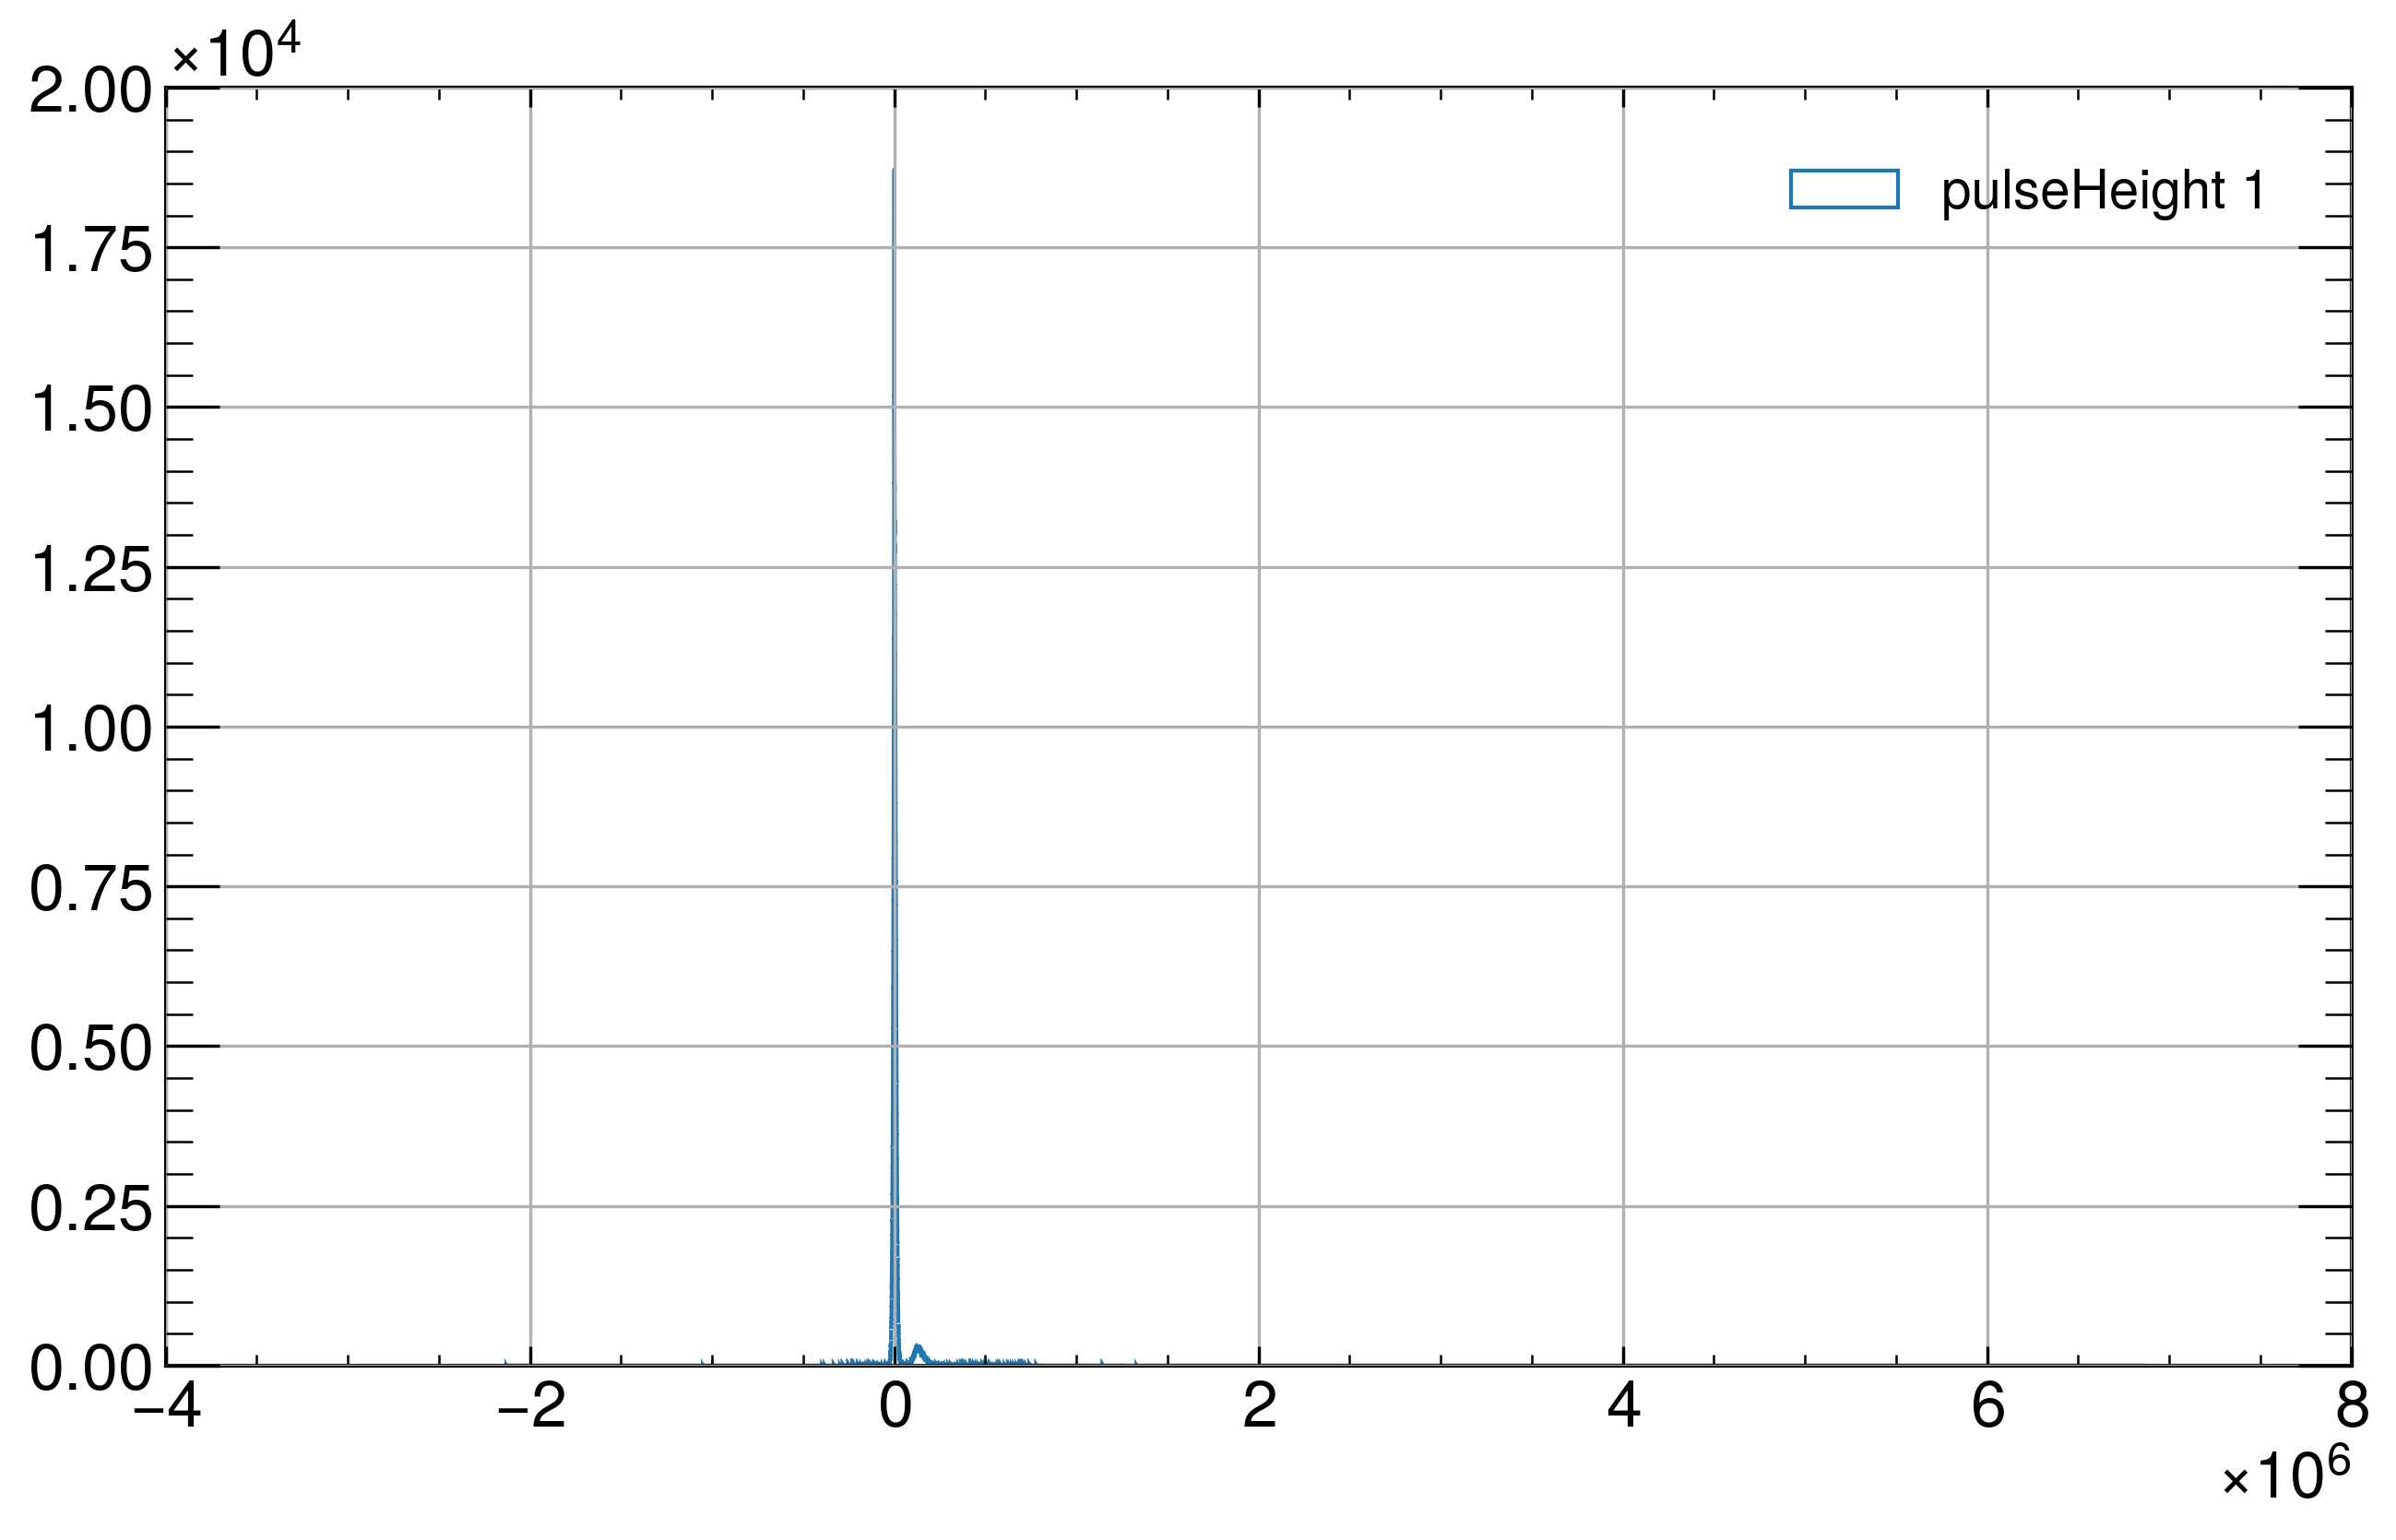

In [99]:
_,hist_bins,_,fig,ax = plot_histogram(df[this_scope]["charge_1"], label="pulseHeight 1")
pulse_cut = df[this_scope]["pulseHeight_1"]>53.8
time_cut = np.logical_and((df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"])>my_bins[info_peak['left_bases'][0]],
                          (df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"])<my_bins[info_peak['right_bases'][0]])
### 2 ns
plot_histogram(df[this_scope]["charge_1"].loc[time_cut], bins=hist_bins, fig_ax=(fig,ax), label="pulseHeight 1 timecut")
ax.semilogy()
ax.set_xlim(-5e5,2e6)
# ax.legend();

In [ ]:
# # _,hist_bins,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(time_cut)])
# _,_,_,fig,ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(pulse_cut)],bins=hist_bins)#, fig_ax=(fig,ax))
# ax.semilogy() 
# fig

Text(0.5, 1.15, 'Time difference with ratio plot when pulseHeight cut is applied \n Batch: 410, Oscilloscope: S1')

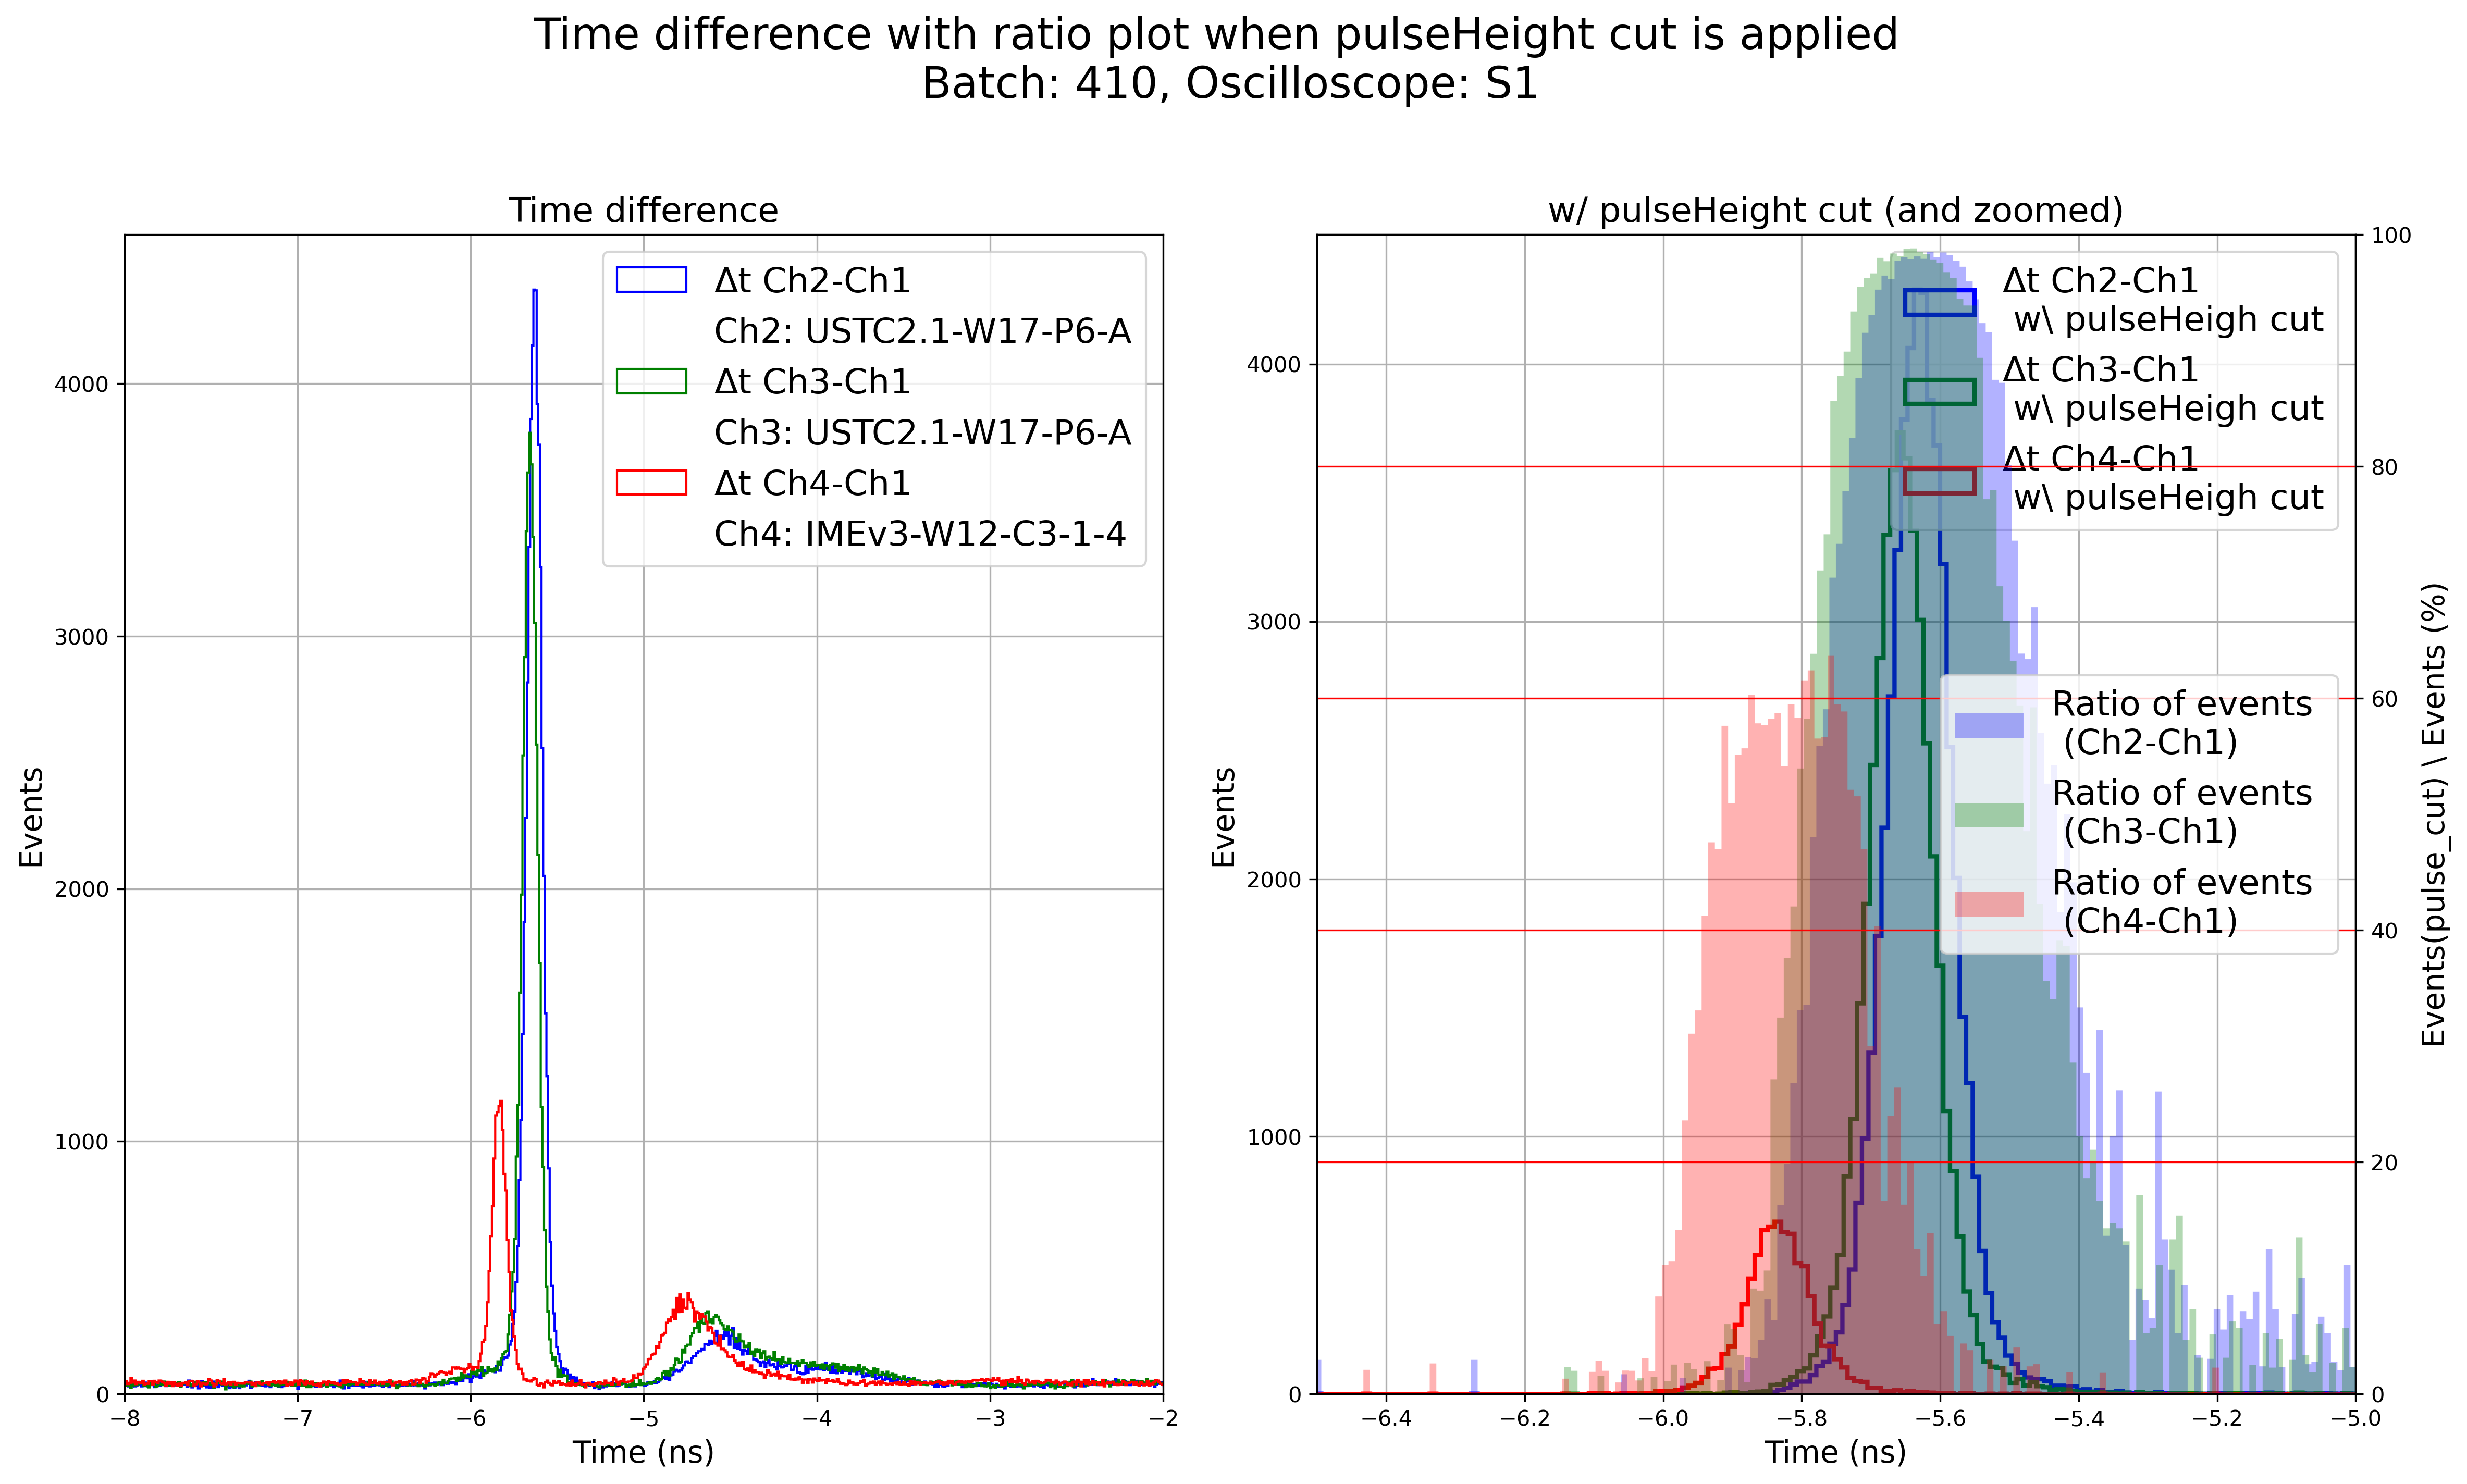

In [47]:
### THIS IS PLOTTING THE RATIO OF DATA THAT IS LEFT WHEN APPLYIN A PULSEHEIGHT CUT
this_scope = "S1"
mins = {"S1":[0,53.8,52.1,65.3], "S2":[0,37.9,51.6,64.3]}

colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2, dpi=300)
fig.tight_layout(w_pad=4, h_pad=4)
ax2 = axes[1].twinx() 
ax2.grid('-', axis='y', color='r')

for dut in range(1,4):
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist, my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"$\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[0]), color=colormap[dut]) ### MCP - CERN1
    axes[0].plot([],[],' ',label=f"Ch{dut+1}: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}")
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"$\Delta$t Ch{dut+1}-Ch1 \n w\ pulseHeigh cut", fig_ax=(fig,axes[1]), linewidth=2, color=colormap[dut])  ### MCP - CERN3
#     time_peak,_ = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10)
    ratio = np.divide(hist_pulse_cut, hist, where = hist!=0)
#     axes[0].stairs(ratio*100, my_bins, alpha=0.5, label='Filtered Ratio', color=colormap[dut])
    ax2.stairs(ratio*100, my_bins, alpha=0.3, label=f"Ratio of events \n (Ch{dut+1}-Ch1)", color=colormap[dut], fill=True)


axes[0].set_title(f"Time difference", fontsize=16)
axes[0].set_xlabel("Time (ns)", fontsize=14)
axes[0].set_ylabel("Events", fontsize=14)
axes[0].set_xlim(-8,-2)

axes[1].set_title("w/ pulseHeight cut (and zoomed)", fontsize=16)
axes[1].set_xlabel("Time (ns)", fontsize=14)
axes[1].set_ylabel("Events", fontsize=14)
axes[1].set_xlim(-6.5,-5)

ax2.set_ylabel("Events(pulse_cut) \ Events (%)", fontsize=14)
ax2.set_ylim(0,100)
ax2.tick_params

axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
ax2.legend(fontsize=16, loc='right')
fig.suptitle(f"Time difference with ratio plot when pulseHeight cut is applied \
\n Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.15, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_{this_scope}_all_DUTs_with_ratio_plot.jpg",bbox_inches='tight')

peak position: -5.891104 ns
peak position: -5.6994157 ns


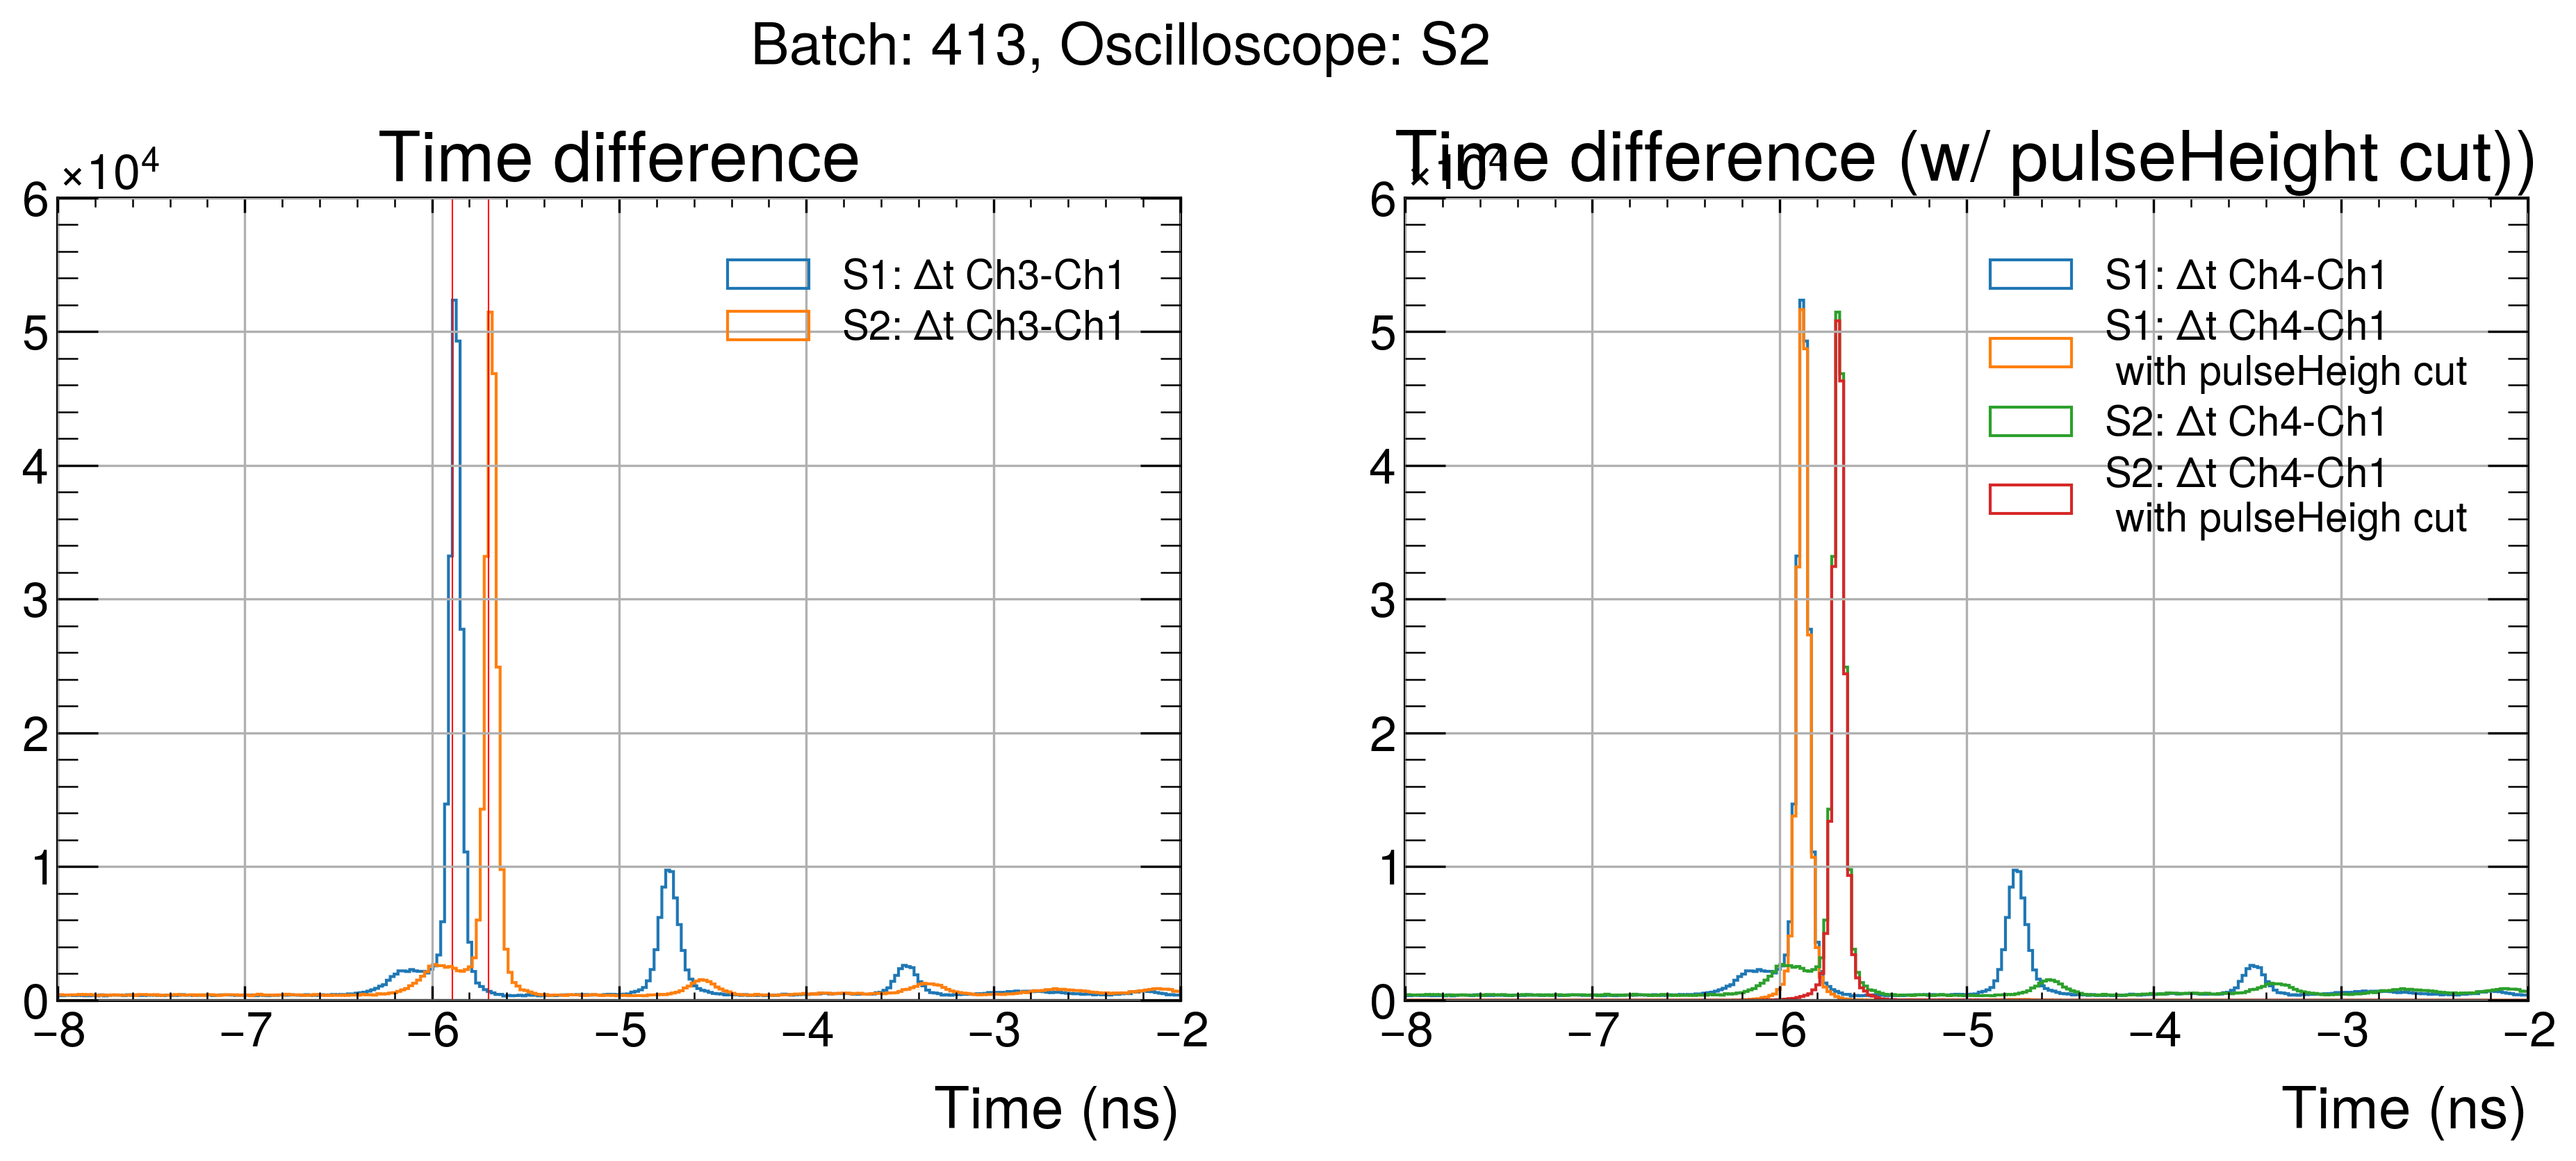

In [101]:
dut = 3

fig, axes = plt.subplots(figsize=(15,5),nrows=1,ncols=2, dpi=300)
for this_scope in ["S1","S2"]:
    pulse_cut = df[this_scope][f"pulseHeight_{dut}"]>mins[this_scope][dut]
    hist,my_bins,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=10000, label=f"{this_scope}: $\Delta$t Ch{dut}-Ch1",fig_ax=(fig,axes[0])) ### MCP - CERN1
    plot_histogram((df[this_scope][f"timeCFD50_{dut}"]-df[this_scope]["timeCFD50_0"])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1",fig_ax=(fig,axes[1]));### MCP - CERN1
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[this_scope][f"timeCFD50_{dut}"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut])/1000, bins=my_bins, label=f"{this_scope}: $\Delta$t Ch{dut+1}-Ch1 \n with pulseHeigh cut", fig_ax=(fig,axes[1]))  ### MCP - CERN3
    time_peak,_ = find_peaks(hist_pulse_cut, prominence=np.max(hist_pulse_cut)/10) 
    axes[0].axvline(my_bins[time_peak],color='r',linewidth=.5)
    print("peak position:",my_bins[time_peak][0],"ns")
    
    
axes[0].set_title(f"Time difference")
axes[0].set_xlabel("Time (ns)")
axes[0].set_xlim(-8,-2)
axes[1].set_xlim(-8,-2)
axes[1].set_xlabel("Time (ns)")
axes[1].set_title("Time difference (w/ pulseHeight cut))")
axes[0].legend()
axes[1].legend()
fig.suptitle(f"Batch: {this_batch}, Oscilloscope: {this_scope}",y=1.1, fontsize=20)
# fig.savefig(f"../various plots/time_difference{this_batch}_DUT{dut}_with_pulseHeight_cut.jpg",bbox_inches='tight')
# fig.savefig(f"../various plots/time_difference{this_batch}_S{this_scope}_all_DUTs_with_pulseHeight_cut.jpg",bbox_inches='tight')

width of the selection: [77766.19]
position of peak: [-5.619747] ns


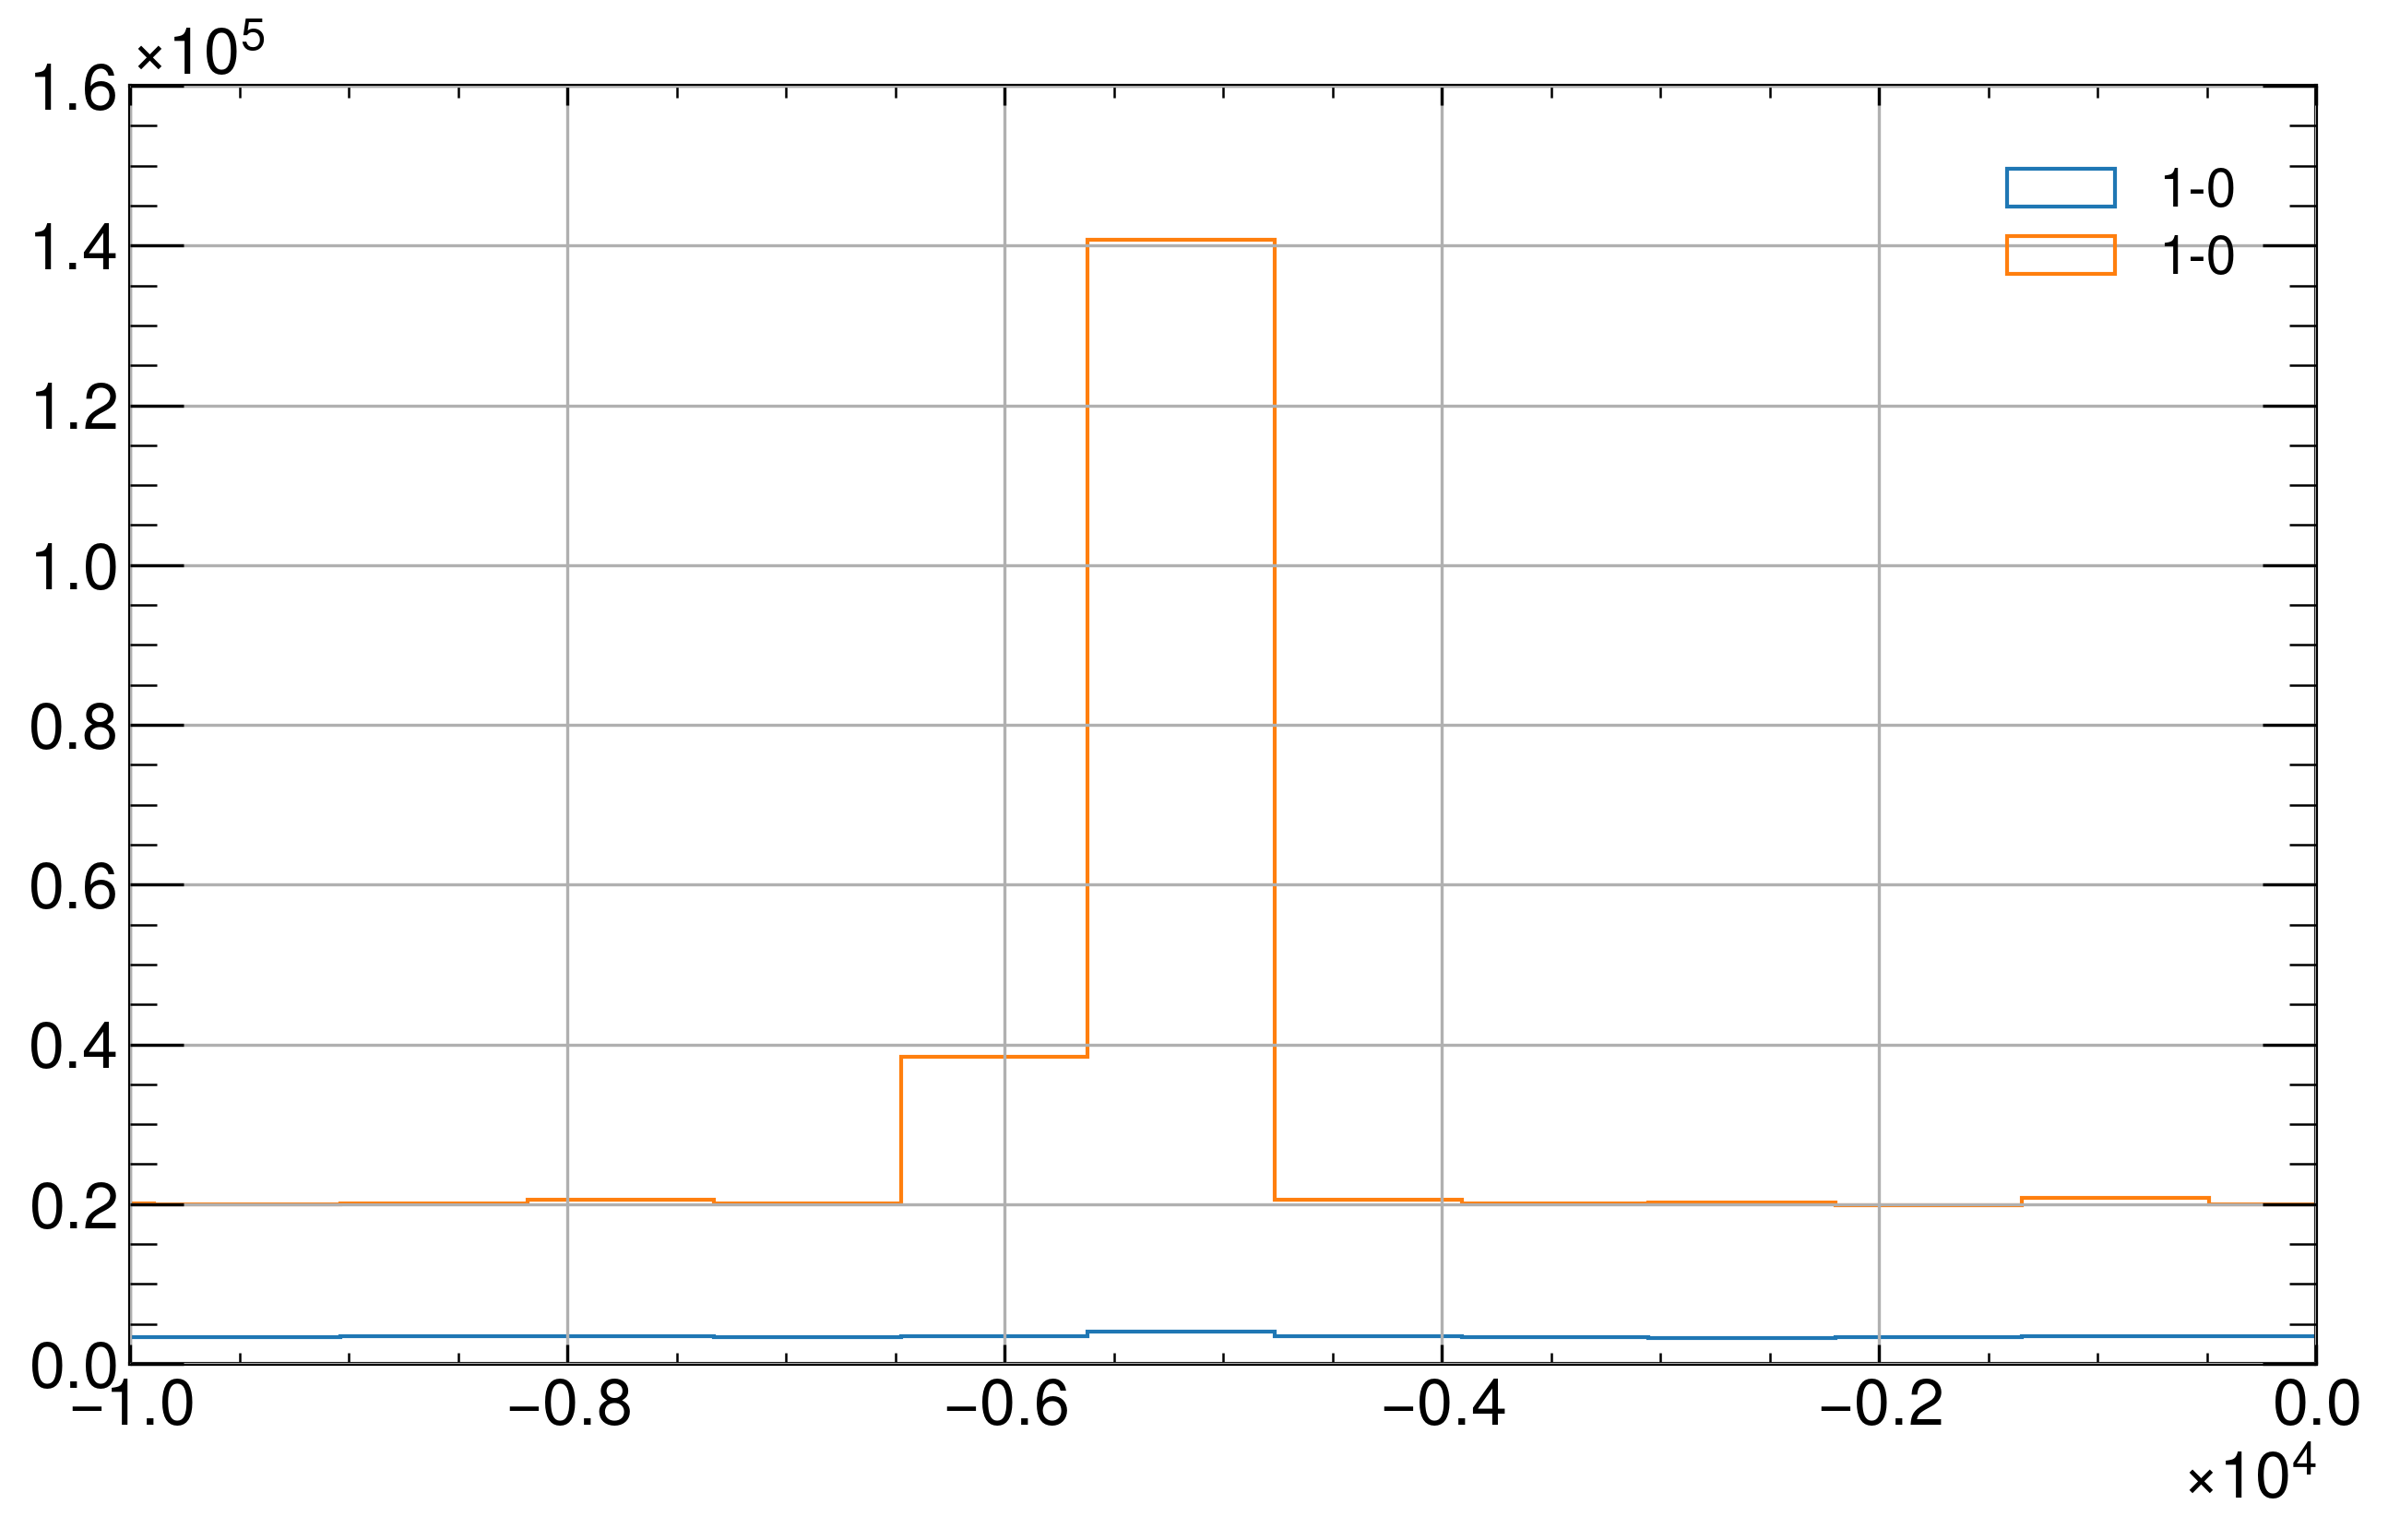

In [141]:

# plot_histogram(df[this_scope]["timeCFD50_2"]-df[this_scope]["timeCFD50_0"], label="2-0", fig_ax=(fig,ax))  ### MCP - CERN3
my_hist,my_bins,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_1"].loc[pulse_cut]-df[this_scope]["timeCFD50_0"].loc[pulse_cut], label="1-0")  ### MCP - CERN3
plot_histogram(df[this_scope]["timeCFD50_1"]-df[this_scope]["timeCFD50_0"], bins=my_bins, label="1-0", fig_ax=(fig,ax))  ### MCP - CERN3
peak, info_peak = find_peaks(my_hist, prominence=1000)
ax.set_xlim(-1e4,0)
ax.axvline(my_bins[info_peak['left_bases']],color='r')
ax.axvline(my_bins[info_peak['right_bases']],color='r')
print("width of the selection:",my_bins[info_peak['right_bases']]-my_bins[info_peak['left_bases']])
print("position of peak:", my_bins[peak]/1000, "ns")
ax.legend();

width of the selection: [602.99316]
position of peak: [-5.7116003] ns


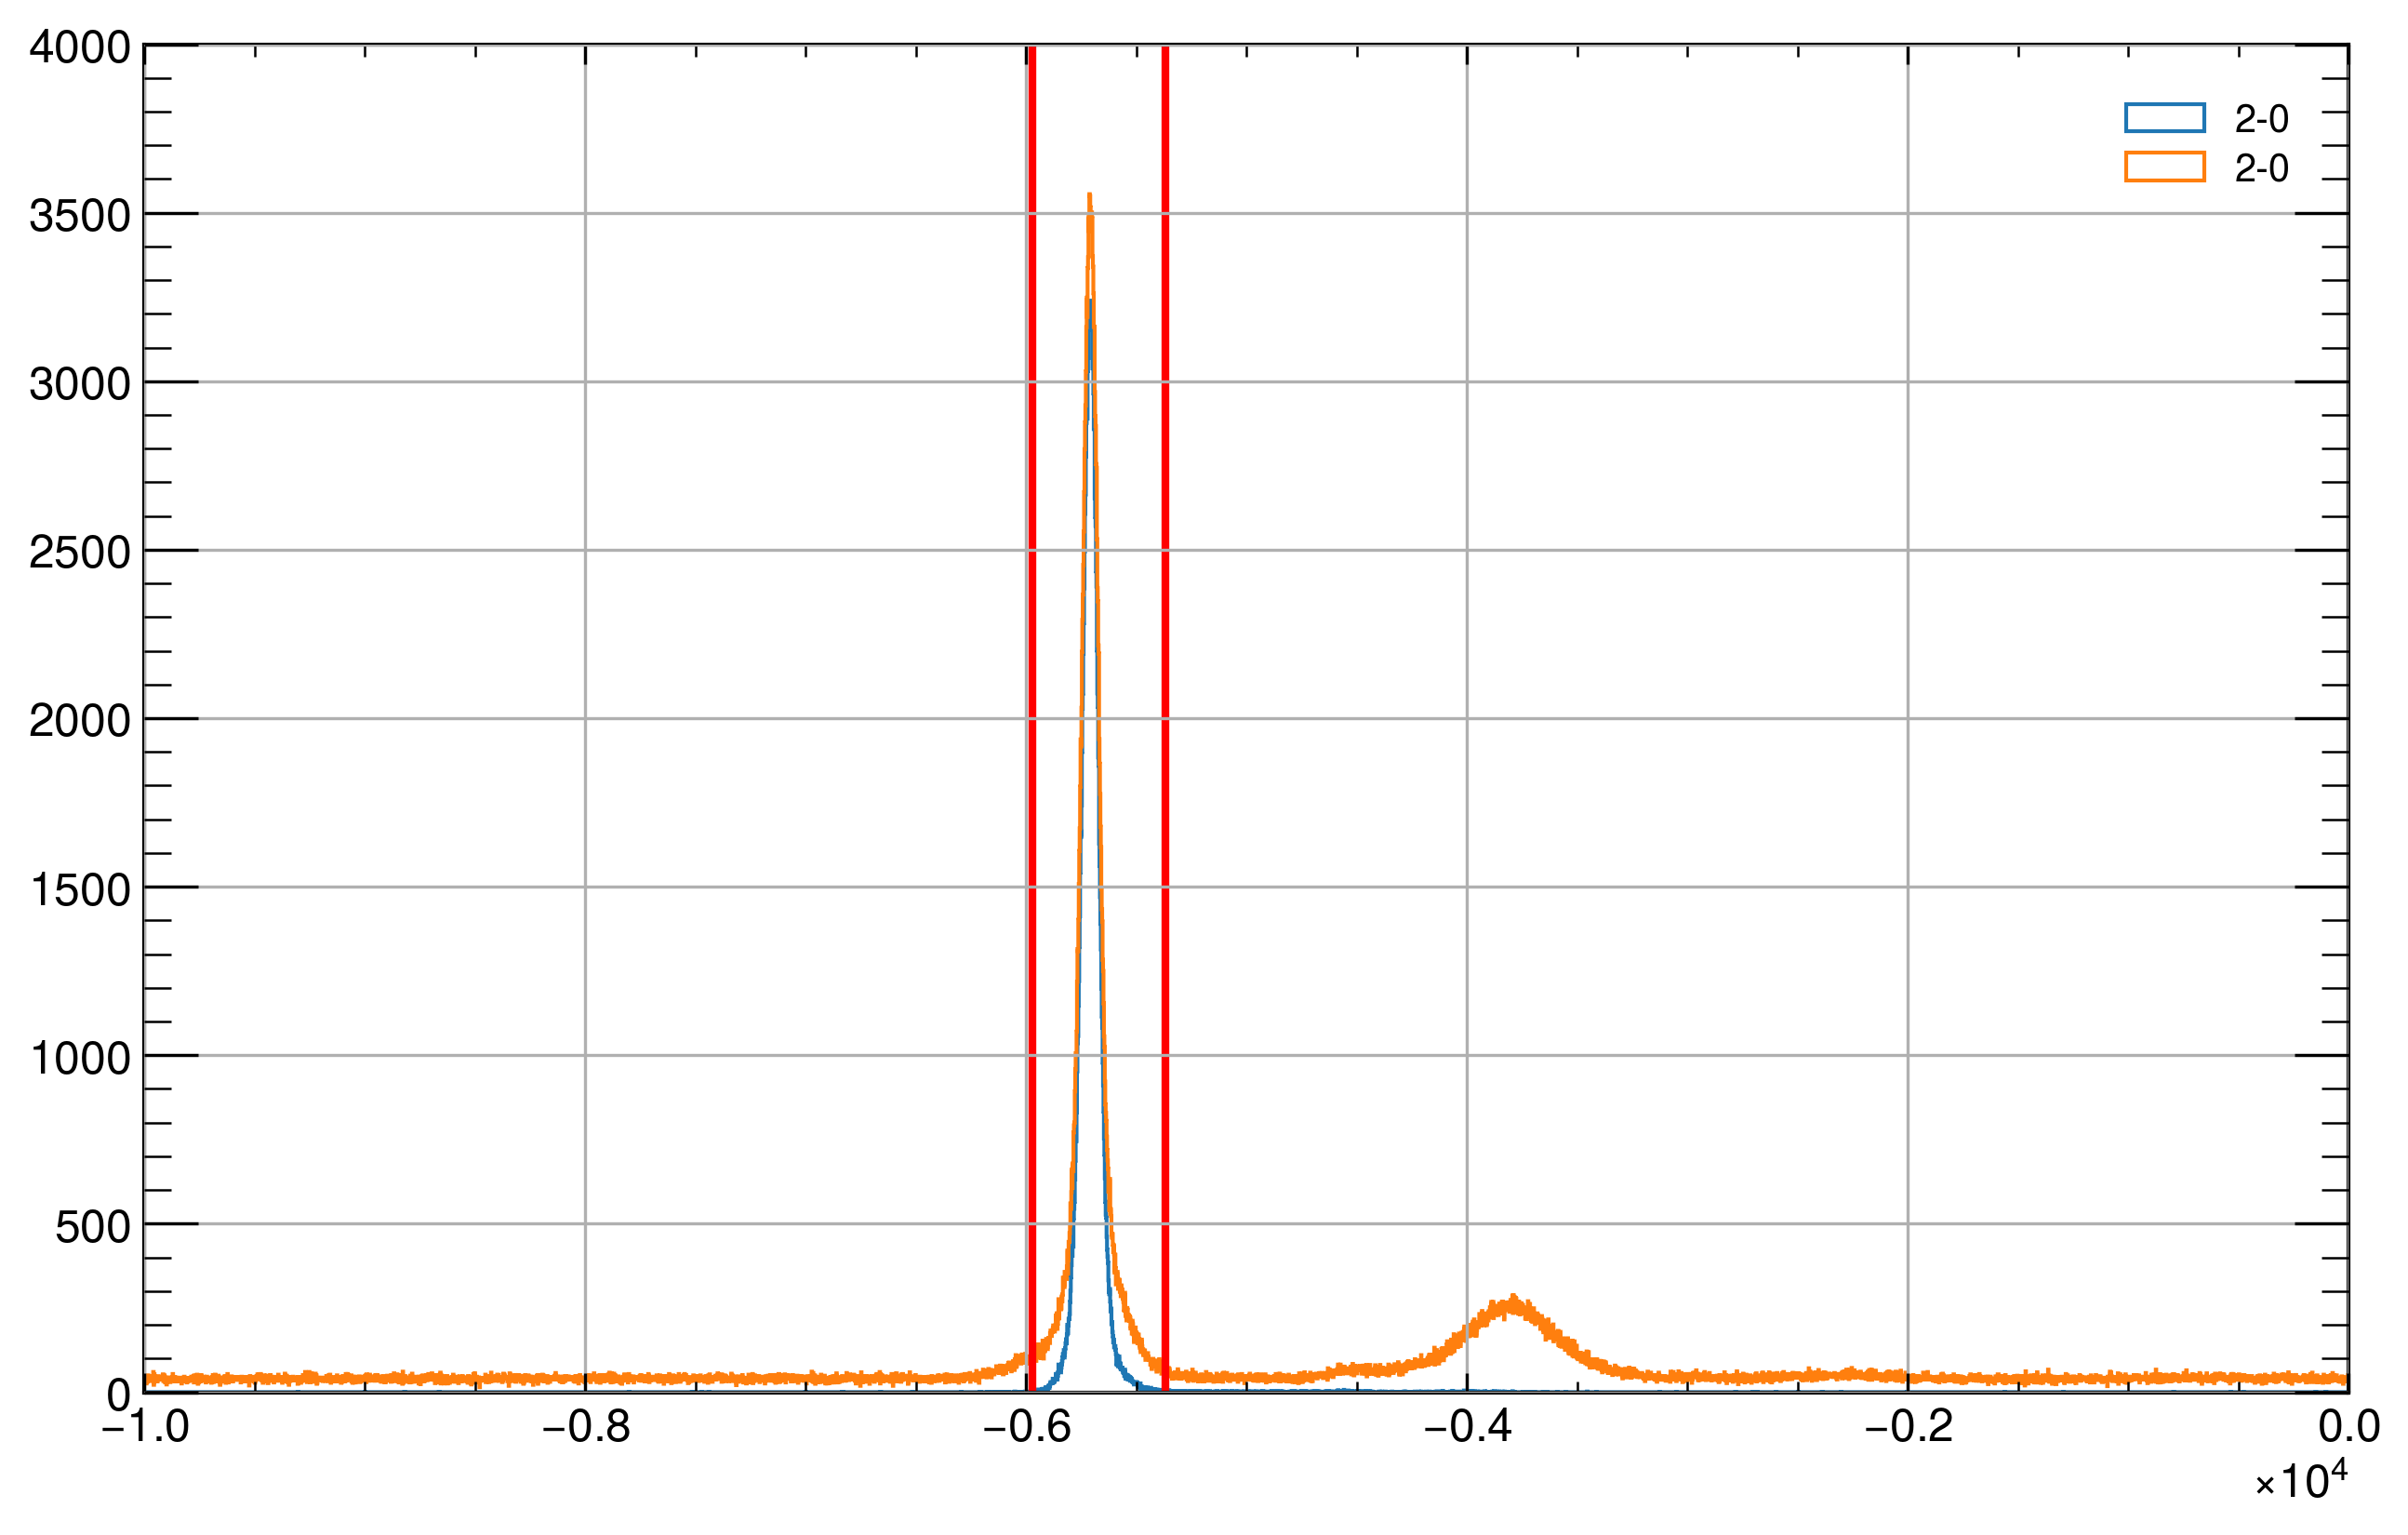

In [203]:
pulse_cut = df[this_scope]["pulseHeight_2"]>52.1

my_hist,my_bins,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_2"].iloc[np.where(pulse_cut)]-df[this_scope]["timeCFD50_0"].iloc[np.where(pulse_cut)], label="2-0")  ### MCP - CERN3
plot_histogram(df[this_scope]["timeCFD50_2"]-df[this_scope]["timeCFD50_0"], bins=my_bins, label="2-0", fig_ax=(fig,ax))  ### MCP - CERN3
peak, info_peak = find_peaks(my_hist, prominence=1000)
ax.set_xlim(-1e4,0)
ax.axvline(my_bins[info_peak['left_bases']],color='r')
ax.axvline(my_bins[info_peak['right_bases']],color='r')
print("width of the selection:",my_bins[info_peak['right_bases']]-my_bins[info_peak['left_bases']])
print("position of peak:", my_bins[peak]/1000, "ns")
ax.legend();

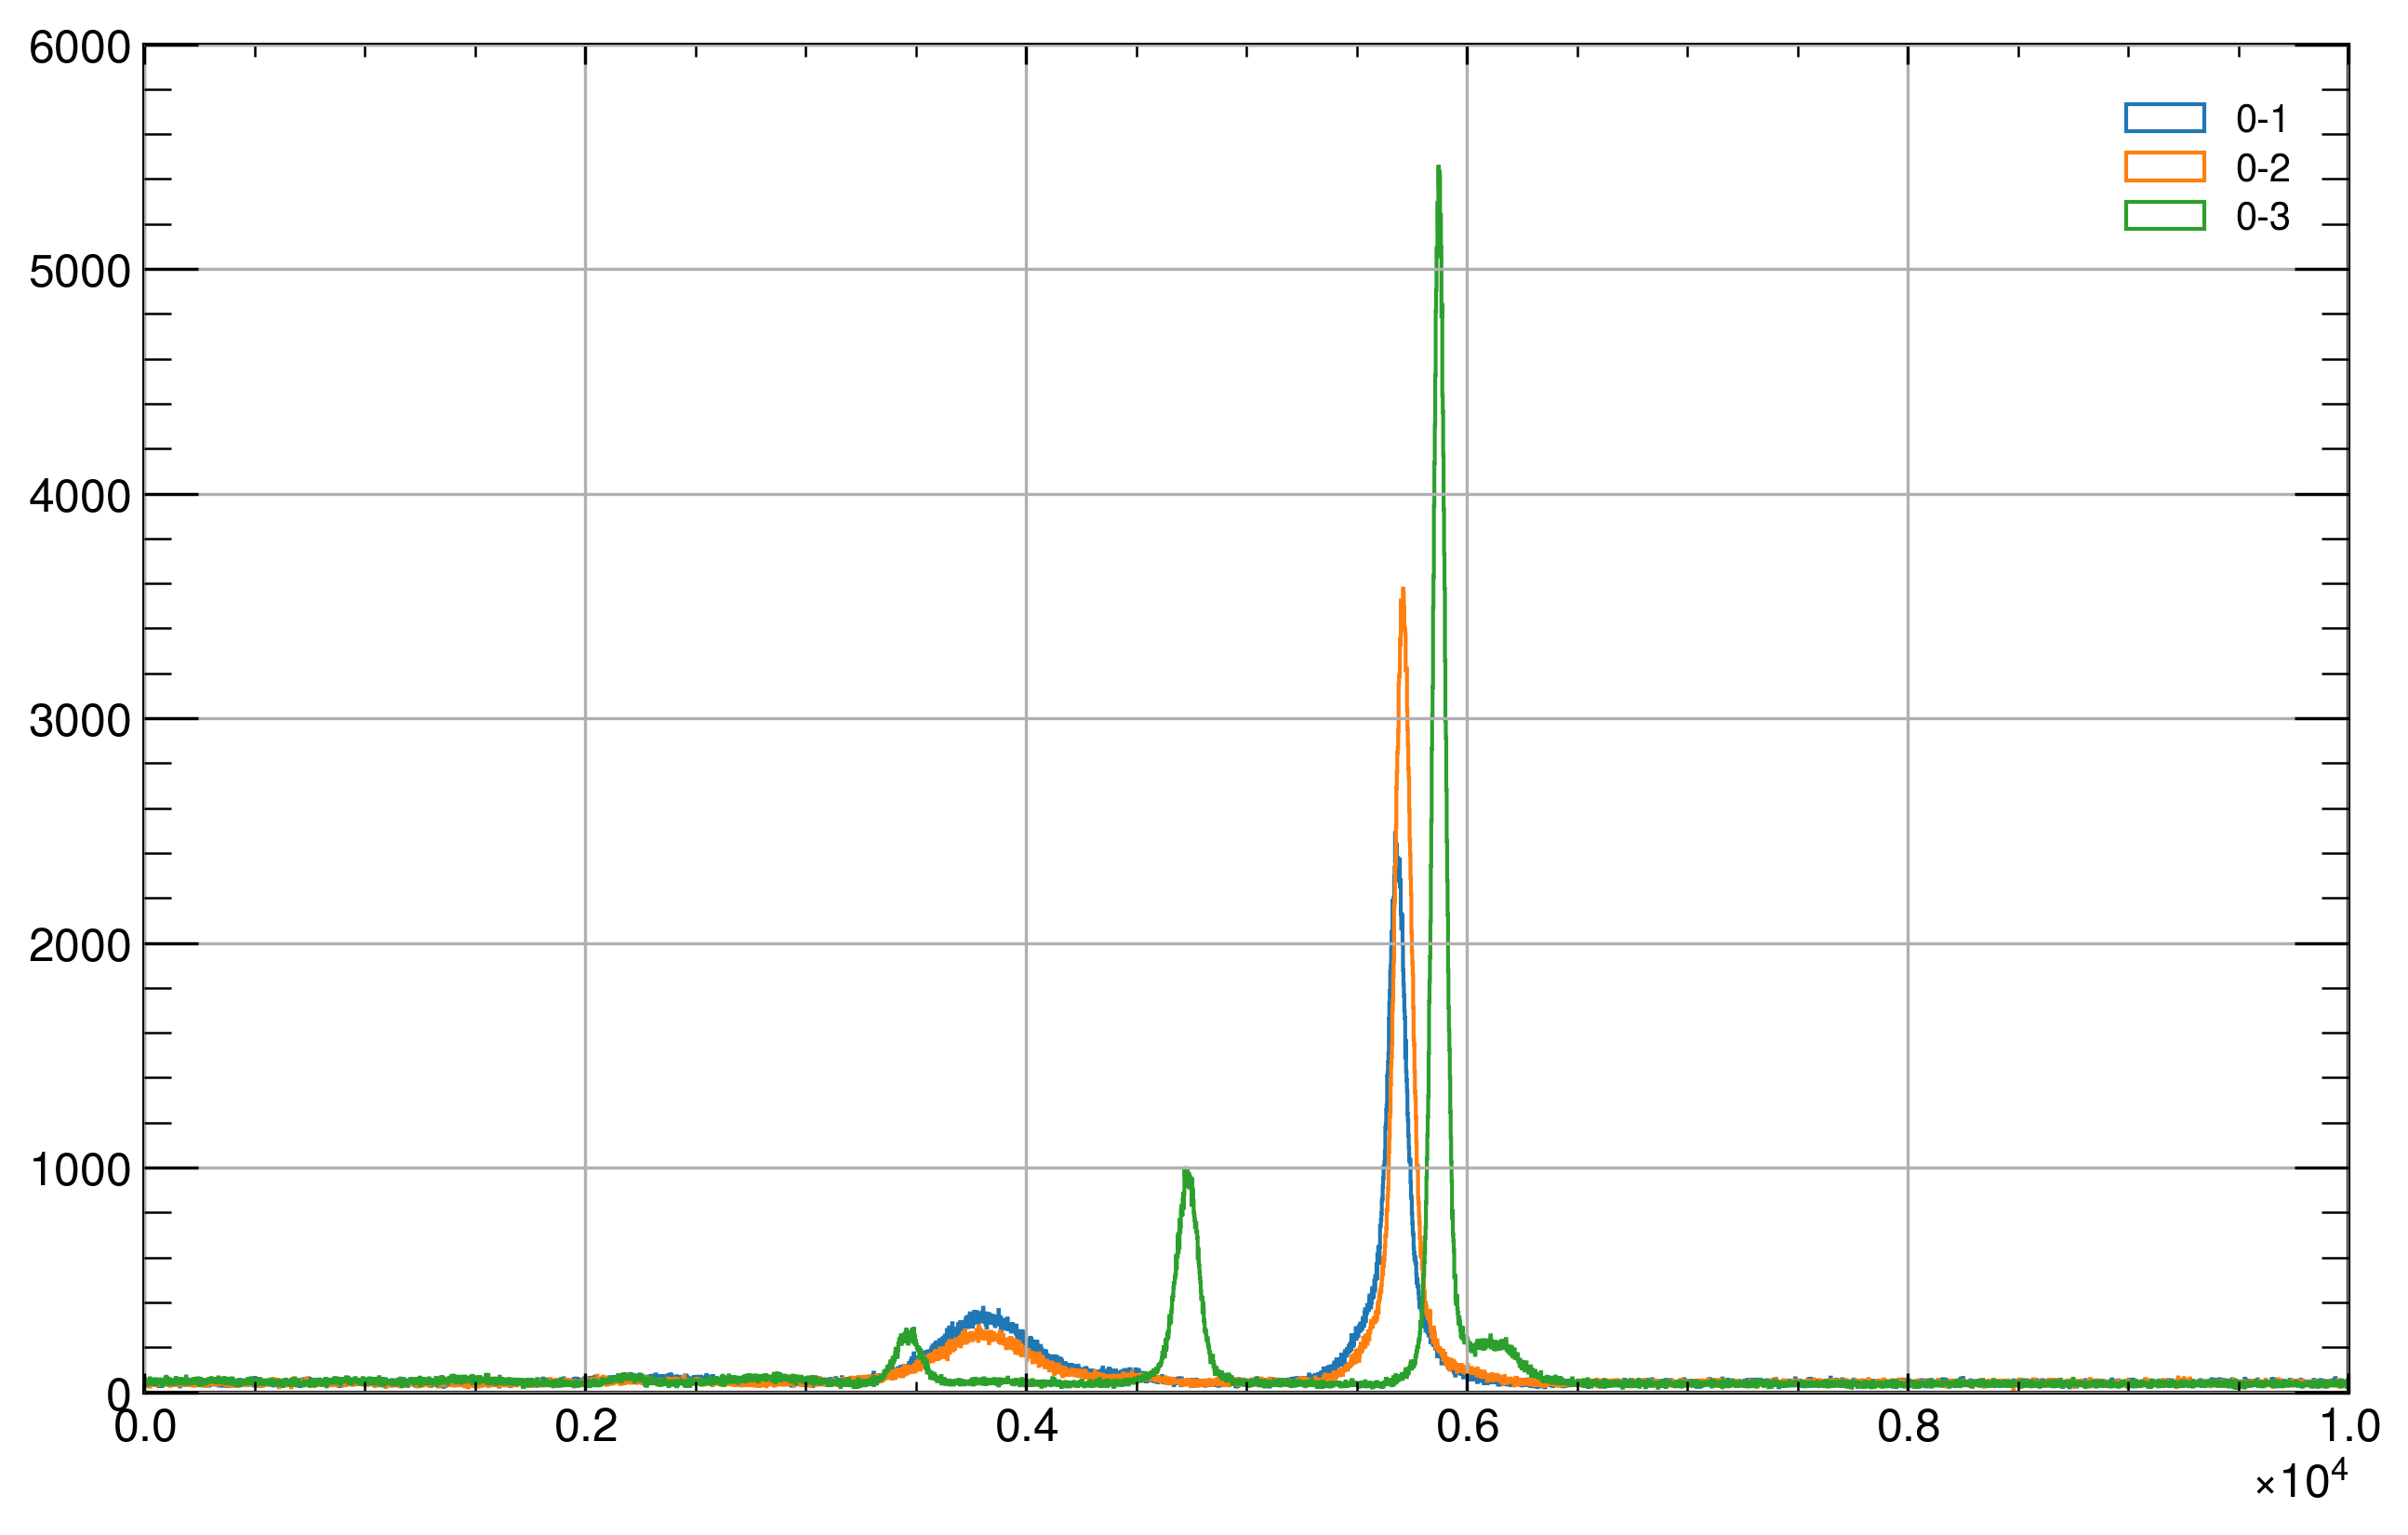

In [176]:
_,_,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_1"],bins=my_bins, label="0-1")
plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_2"],fig_ax=(fig,ax),bins=my_bins, label="0-2")
plot_histogram(df[this_scope]["timeCFD50_0"]-df[this_scope]["timeCFD50_3"],fig_ax=(fig,ax),bins=my_bins, label="0-3")
ax.set_xlim(0,1e4)
ax.legend();

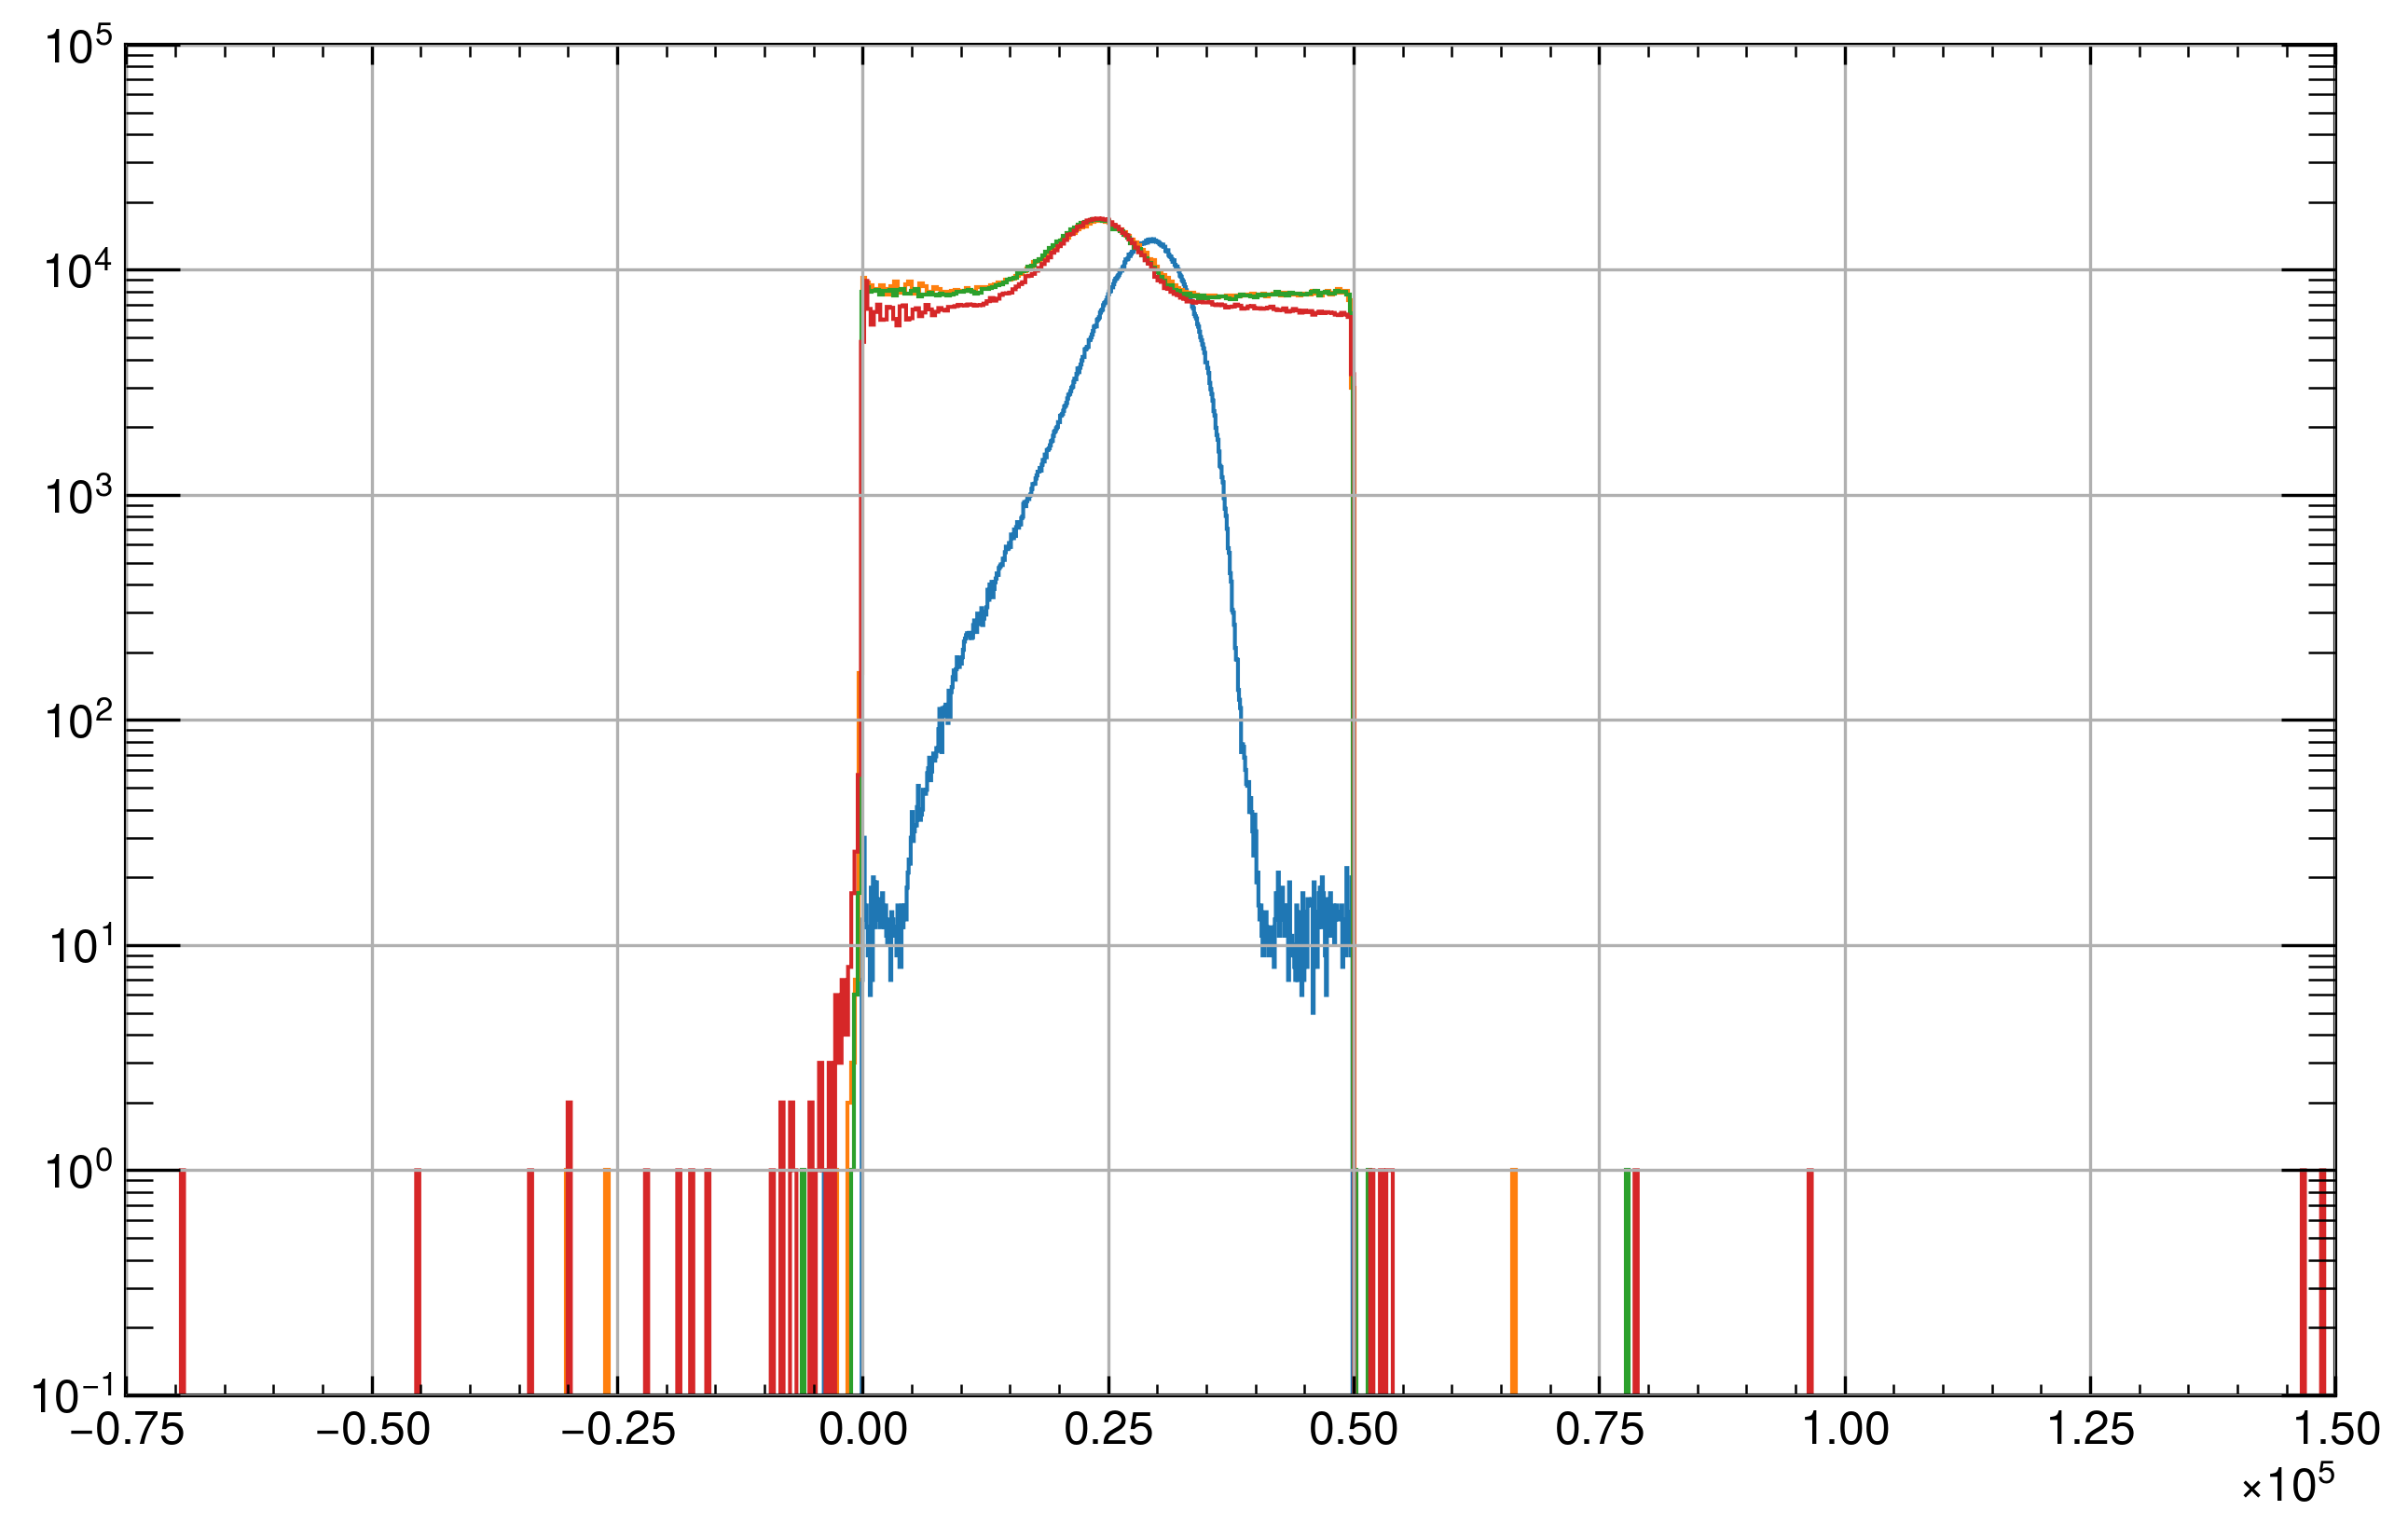

In [70]:
_,_,_,fig,ax = plot_histogram(df[this_scope]["timeCFD50_0"], label="0")
plot_histogram(df[this_scope]["timeCFD50_1"], fig_ax=(fig,ax), label="1")
plot_histogram(df[this_scope]["timeCFD50_2"], fig_ax=(fig,ax), label="2")
plot_histogram(df[this_scope]["timeCFD50_3"], fig_ax=(fig,ax), label="3")
ax.semilogy();

In [ ]:
dict_mins

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
charge_hist, bins_hist, _ = ax.hist(df[this_scope]["charge_1"].iloc[np.where(
    geometry_1.combine(filter_1, my_and))]/transimpedance,
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,1,1,4000))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()
ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
fig.savefig(f"various plots/Charge_distribution_fit_Ch2_{this_batch}.jpg")

In [ ]:
covariance[0,0]**(1/2)

#### I was trying to plot the FE-I4 mask but it does not quite work

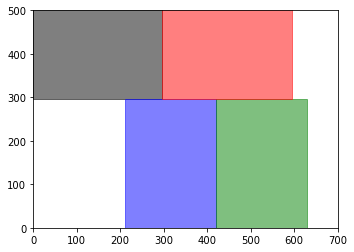

In [65]:
# ### I was trying to plot the FE-I4 mask but it does not quite work

# ### Create a figure and axis
# fig, ax = plt.subplots()
# ### Define the coordinates, width, and height of multiple rectangles
# rectangles = [#(0,0,210,297), # x,y,width, height
#               (0,297,297,210),
#               (210,0,210,297),
#               (420,0,210,297),
#               (297,297,297,210)]

# ### Loop through the list of rectangles and draw them
# for i, rect in enumerate(rectangles):
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True, alpha=0.5, color=colormap[i]))

# ### Set axis limits if needed
# ax.set_xlim(0,700)
# ax.set_ylim(0,500)

# ### Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()